In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import os
from pathlib import Path
import pickle
import timeit
#
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
from dotted_dict import DottedDict
from tqdm import tqdm
import pprint
#
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer
from plot_utils import *

In [4]:
class Net(nn.Module):
    def __init__(self, n_classes, d_in, d_hid=1024, n_hid=0):
        super(Net, self).__init__()
        dims = [d_in]
        for _ in range(n_hid):
            dims.append(d_hid)
        dims.append(n_classes)
        #
        layers = []
        for idx in range(1, len(dims) - 1, 1):
            layers.append(nn.Linear(dims[idx - 1], dims[idx]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

def get_datasets(target_idx, p_R_train, p_R_valid, p_Y_train, p_Y_valid, batch_size):
    #
    R_train = torch.Tensor(np.load(p_R_train))
    R_valid = torch.Tensor(np.load(p_R_valid))
    #
    Y_train = torch.LongTensor(np.load(p_Y_train))
    Y_valid = torch.LongTensor(np.load(p_Y_valid))
    #
    d_r = R_train.shape[1]
    #
    Y_train = Y_train[:, target_idx]
    Y_valid = Y_valid[:, target_idx]
    #
    ds_train = torch.utils.data.TensorDataset(R_train, Y_train)
    ds_valid = torch.utils.data.TensorDataset(R_valid, Y_valid)

    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)
    dl_valid = DataLoader(
        ds_valid,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)
    return dl_train, dl_valid, d_r

def train_model(model, num_epochs, optimizer, criterion):
    stats = {
    'train': {
        'loss': [],
        'acc': [],
        'epoch': [],
    },
    'valid': {
        'loss': [],
        'acc': [],
        'epoch': [],
    }
    }
    stats = DottedDict(stats)
    desc_tmp = "Epoch [{:3}/{:3}] {}:"
    #
    for epoch_idx in range(1, num_epochs + 1, 1):
        ################
        # TRAIN
        ################
        model.train()
        epoch_step = 0
        epoch_loss = 0
        epoch_total = 0
        epoch_correct = 0
        #
        desc = desc_tmp.format(epoch_idx, num_epochs, 'train')
        pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
        #
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            for param in model.parameters():
                param.grad = None
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            #
            _, y_pred = torch.max(out, 1)
            total = y.size(0)
            correct = (y_pred == y).sum().item()
            #
            epoch_loss += loss.item()
            epoch_total += total
            epoch_correct += correct
            epoch_step += 1
            #
            pbar.set_postfix({'loss': loss.item(), 'acc': correct / total})
        stats.train.loss.append(epoch_loss / epoch_step)
        stats.train.acc.append(epoch_correct / epoch_total)
        stats.train.epoch.append(epoch_idx)

        ################
        # EVAL
        ################
        model.eval()
        epoch_step = 0
        epoch_loss = 0
        epoch_total = 0
        epoch_correct = 0
        #
        desc = desc_tmp.format(epoch_idx, num_epochs, 'valid')
        pbar = tqdm(dl_valid, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
        #
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                out = model(x)
                loss = criterion(out, y)
            #
            _, y_pred = torch.max(out, 1)
            total = y.size(0)
            correct = (y_pred == y).sum().item()
            #
            epoch_loss += loss.item()
            epoch_total += total
            epoch_correct += correct
            epoch_step += 1
            #
            pbar.set_postfix({'loss': loss.item(), 'acc': correct / total})
            #
        stats.valid.loss.append(epoch_loss / epoch_step)
        stats.valid.acc.append(epoch_correct / epoch_total)
        stats.valid.epoch.append(epoch_idx)
    return stats

# Settings

In [5]:
# linprob config
linprob_config = {
    'p_eval': 'eval',
    'p_eval_results': 'results.pkl',
    'p_config': "linprob_config.pkl",
    'p_results': 'results.pkl',
    'device': "cuda",
    'cuda_visible_devices': '0',
    'n_hid': 0,
    'd_hid': 1024,
    'batch_size': 1024,
    'optimizer': 'adam',
    'optimizer_args': {'lr': 0.001, 'weight_decay': 1e-6},
    'num_epochs': 20,
    'eval_name': "Width_and_Depth"
}
linprob_config = DottedDict(linprob_config)

In [6]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = linprob_config.cuda_visible_devices
device = torch.device(linprob_config.device)

In [ ]:
p_experiments_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c128_a32_p10_s3_bg_inf_random_function_100000")
p_experiments_base = p_experiments_base / "beta"
experiment_names = [
    "Beta_w8_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-26-36",
    "Beta_w8_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-56-29",
    "Beta_w8_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-26-26",
    "Beta_w8_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_18-56-30",
    "Beta_w16_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-27-56",
    "Beta_w16_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-57-28",
    "Beta_w16_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-27-05",
    "Beta_w16_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-56-43",
    "Beta_w32_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_00-29-59",
    "Beta_w32_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-28-55",
    "Beta_w32_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-58-22",
    "Beta_w32_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-59-27",
    "Beta_w64_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_01-31-01",
    "Beta_w64_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_01-00-30",
    "Beta_w64_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_02-01-25",
    "Beta_w64_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_02-31-53",
    "Beta_w128_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-33-57",
    "Beta_w128_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-02-22",
    "Beta_w128_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-03-29",
    "Beta_w128_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-32-53",
    "Beta_w256_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-36-04",
    "Beta_w256_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_05-34-55",
    "Beta_w256_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_05-04-23",
    "Beta_w256_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-05-29",
    "Beta_w512_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-38-17",
    "Beta_w512_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-07-42",
    "Beta_w512_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-37-07",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_18-51-20",
    "Beta_w1024_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-08-54",
    "Beta_w1024_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-39-36",
    "Beta_w1024_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-10-18",
    "Beta_w1024_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-39-43",
]

p_experiments = [p_experiments_base / name for name in experiment_names]

for p in p_experiments:
    assert p.exists()

In [10]:
p_experiments_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c128_a32_p10_s3_bg_inf_random_function_100000")
p_experiments_base = p_experiments_base / "beta"
experiment_names = [
    "Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28",
    "Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48",
    "Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30",
    "Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06",
    "Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33",
    "Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55",
    "Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10",
    "Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13",
    "Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53",
    "Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35",
    "Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54",
    "Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36",
    "Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16",
    "Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47",
    "Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09",
    "Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18",
    "Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32",
    "Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04",
    "Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46",
    "Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32",
    "Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43",
    "Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22",
    "Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51",
    "Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14",
    "Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23",
    "Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32",
    "Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05",
]

p_experiments = [p_experiments_base / name for name in experiment_names]

for p in p_experiments:
    assert p.exists()

In [11]:
names = []
for p in list(p_experiments_base.glob("*")):
    if p.name in experiment_names:
        continue
    print(p.name)
    #if "w1024" in p.name and "alpha_0.5" in p.name and "wdkl_10" in p.name:
    #    print(p.name) 

Beta_w128_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-33-57
Beta_w1024_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-39-43
Beta_w256_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-36-04
Beta_w8_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-26-36
Beta_w128_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-02-22
Beta_w1024_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-08-54
Beta_w32_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_00-29-59
Beta_w32_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-28-55
Beta_w16_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-27-56
Beta_w8_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-56-29
Beta_w16_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-57-28
Beta_w512_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-38-17
Beta_w32_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-58-22
Beta_w32_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-59-27


In [21]:
step = 1
max_steps = len(p_experiments) * 2 * 6
print_str = "[{:>3}/{:>3}] {:>10} {:<10} {}"
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    
    # experiment config
    p_experiment_config = p_experiment / "config.pkl"
    with open(p_experiment_config, "rb") as file:
        experiment_config = pickle.load(file)
    # dataset config
    p_ds_config = Path(experiment_config.p_data) / "config.pkl"
    with open(p_ds_config, "rb") as file:
        ds_config = pickle.load(file)
    ds_reps = {
            "bacbone": {
                "R_train": experiment_config["p_R_train"],
                "R_valid": experiment_config["p_R_valid"],
                "Y_train": experiment_config["p_Y_train"],
                "Y_valid": experiment_config["p_Y_valid"],
                  },
           "betapro": {
               "R_train": experiment_config["p_R_train_bp"],
               "R_valid": experiment_config["p_R_valid_bp"],
               "Y_train": experiment_config["p_Y_train_bp"],
               "Y_valid": experiment_config["p_Y_valid_bp"],
                }
           }
    results = {ds_key: {} for ds_key in ds_reps.keys()}
    for ds_key in ds_reps.keys():
        for target_variable in ds_config["classes"]:
            print(print_str.format(step, max_steps, ds_key, target_variable, experiment_name))
            target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
            n_classes = ds_config["n_classes"][target_variable]
            #
            dl_train, dl_valid, d_r = get_datasets(target_idx,
                                                   p_experiment / ds_reps[ds_key]["R_train"],
                                                   p_experiment / ds_reps[ds_key]["R_valid"],
                                                   p_experiment / ds_reps[ds_key]["Y_train"],
                                                   p_experiment / ds_reps[ds_key]["Y_valid"],
                                                   linprob_config.batch_size
                                                  )
            #
            model = Net(n_classes, d_r, linprob_config.d_hid, linprob_config.n_hid)
            model = model.to(device)
            #
            optimizer = get_optimizer(linprob_config.optimizer, model.parameters(), linprob_config.optimizer_args)
            criterion = nn.CrossEntropyLoss()
            #
            stats = train_model(model, linprob_config.num_epochs, optimizer, criterion)
            results[ds_key][target_variable] = stats
            step += 1
    p_results = p_experiment / linprob_config["p_results"]
    p_linprob_config = p_experiment / linprob_config["p_config"]
    #
    with open(p_results, "wb") as file:
        pickle.dump(results, file)
    with open(p_linprob_config, "wb") as file:
        pickle.dump(linprob_config, file)

[  1/360]    bacbone shape      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 53.57it/s, loss=0.825, acc=0.734]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 75.93it/s, loss=0.818, acc=0.756]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 87.76it/s, loss=0.657, acc=0.772]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 110.45it/s, loss=0.633, acc=0.793]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 103.17it/s, loss=0.594, acc=0.775]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 156.73it/s, loss=0.592, acc=0.801]                                                                          
Epoch [  4/ 20] train:

[  2/360]    bacbone scale      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.14it/s, loss=1.03, acc=0.479]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.77it/s, loss=1.03, acc=0.454]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 93.09it/s, loss=0.993, acc=0.502]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 92.32it/s, loss=0.985, acc=0.491]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 79.65it/s, loss=0.972, acc=0.518]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.98it/s, loss=0.974, acc=0.503]                                                                           
Epoch [  4/ 20] train:

[  3/360]    bacbone color      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 65.57it/s, loss=4.54, acc=0.0225]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 85.33it/s, loss=4.58, acc=0.0128]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 69.74it/s, loss=4.41, acc=0.0264]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 122.89it/s, loss=4.42, acc=0.0204]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 75.91it/s, loss=4.33, acc=0.042]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 108.24it/s, loss=4.32, acc=0.037]                                                                           
Epoch [  4/ 20] train:

[  4/360]    bacbone angle      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 54.35it/s, loss=2.9, acc=0.113]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 91.33it/s, loss=2.89, acc=0.12]                                                                             
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 76.03it/s, loss=2.8, acc=0.144]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 62.10it/s, loss=2.81, acc=0.142]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 76.39it/s, loss=2.68, acc=0.161]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 46.56it/s, loss=2.7, acc=0.145]                                                                             
Epoch [  4/ 20] train:

[  5/360]    bacbone py         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 59.42it/s, loss=1.76, acc=0.329]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 52.59it/s, loss=1.76, acc=0.302]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 81.05it/s, loss=1.61, acc=0.337]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 126.11it/s, loss=1.62, acc=0.343]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 99.23it/s, loss=1.52, acc=0.402]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 120.75it/s, loss=1.53, acc=0.399]                                                                           
Epoch [  4/ 20] train:

[  6/360]    bacbone px         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 85.44it/s, loss=2.27, acc=0.132]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 101.18it/s, loss=2.28, acc=0.125]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 85.58it/s, loss=2.23, acc=0.181]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 128.49it/s, loss=2.25, acc=0.167]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 80.96it/s, loss=2.2, acc=0.208]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 85.61it/s, loss=2.2, acc=0.219]                                                                             
Epoch [  4/ 20] train:

[  7/360]    betapro shape      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 111.12it/s, loss=1.84, acc=0.332]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 81.85it/s, loss=1.82, acc=0.355]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 105.60it/s, loss=1.73, acc=0.402]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 103.85it/s, loss=1.72, acc=0.413]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 91.45it/s, loss=1.64, acc=0.487]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.87it/s, loss=1.63, acc=0.477]                                                                            
Epoch [  4/ 20] train:

[  8/360]    betapro scale      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 68.87it/s, loss=1.1, acc=0.358]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 129.78it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 121.45it/s, loss=1.1, acc=0.357]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 129.00it/s, loss=1.09, acc=0.389]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 120.43it/s, loss=1.1, acc=0.361]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 72.79it/s, loss=1.09, acc=0.394]                                                                            
Epoch [  4/ 20] train:

[  9/360]    betapro color      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 89.13it/s, loss=4.87, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 100.52it/s, loss=4.82, acc=0.014]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 118.33it/s, loss=4.81, acc=0.023]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 95.11it/s, loss=4.79, acc=0.0268]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 62.39it/s, loss=4.77, acc=0.0293]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 91.32it/s, loss=4.76, acc=0.0268]                                                                           
Epoch [  4/ 20] train:

[ 10/360]    betapro angle      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 127.95it/s, loss=3.4, acc=0.0816]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 107.23it/s, loss=3.38, acc=0.0804]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 78.08it/s, loss=3.32, acc=0.0995]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 119.84it/s, loss=3.31, acc=0.124]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 111.22it/s, loss=3.27, acc=0.0957]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 120.27it/s, loss=3.25, acc=0.111]                                                                           
Epoch [  4/ 20] train:

[ 11/360]    betapro py         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 61.01it/s, loss=2.28, acc=0.165]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 92.35it/s, loss=2.28, acc=0.14]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 114.46it/s, loss=2.26, acc=0.153]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 126.19it/s, loss=2.26, acc=0.153]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 117.61it/s, loss=2.24, acc=0.168]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 70.69it/s, loss=2.24, acc=0.184]                                                                            
Epoch [  4/ 20] train:

[ 12/360]    betapro px         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.00it/s, loss=2.31, acc=0.106]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 91.69it/s, loss=2.3, acc=0.107]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 89.29it/s, loss=2.3, acc=0.124]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 84.34it/s, loss=2.29, acc=0.121]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 52.80it/s, loss=2.29, acc=0.128]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.96it/s, loss=2.29, acc=0.131]                                                                           
Epoch [  4/ 20] train:

[ 13/360]    bacbone shape      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.89it/s, loss=0.773, acc=0.772]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.80it/s, loss=0.754, acc=0.793]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 89.55it/s, loss=0.586, acc=0.818]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 85.00it/s, loss=0.633, acc=0.805]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 95.77it/s, loss=0.542, acc=0.828]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 87.93it/s, loss=0.508, acc=0.835]                                                                           
Epoch [  4/ 20] train:

[ 14/360]    bacbone scale      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 72.85it/s, loss=1.01, acc=0.505]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 93.33it/s, loss=1.02, acc=0.508]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 91.44it/s, loss=0.989, acc=0.512]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 66.42it/s, loss=0.974, acc=0.522]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 86.86it/s, loss=0.94, acc=0.556]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 59.25it/s, loss=0.958, acc=0.557]                                                                           
Epoch [  4/ 20] train:

[ 15/360]    bacbone color      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 86.34it/s, loss=4.54, acc=0.0342]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 89.40it/s, loss=4.56, acc=0.0217]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 86.76it/s, loss=4.43, acc=0.0244]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 85.77it/s, loss=4.42, acc=0.0306]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 89.19it/s, loss=4.34, acc=0.0371]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.85it/s, loss=4.33, acc=0.037]                                                                           
Epoch [  4/ 20] train:

[ 16/360]    bacbone angle      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 95.67it/s, loss=2.9, acc=0.118]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 104.42it/s, loss=2.86, acc=0.162]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 82.88it/s, loss=2.71, acc=0.156]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 79.86it/s, loss=2.7, acc=0.167]                                                                             
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 78.02it/s, loss=2.64, acc=0.177]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 74.07it/s, loss=2.64, acc=0.161]                                                                            
Epoch [  4/ 20] train:

[ 17/360]    bacbone py         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 91.11it/s, loss=1.73, acc=0.336]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 105.24it/s, loss=1.76, acc=0.297]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 82.01it/s, loss=1.6, acc=0.356]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 105.66it/s, loss=1.61, acc=0.357]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 82.73it/s, loss=1.5, acc=0.418]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 76.72it/s, loss=1.54, acc=0.389]                                                                            
Epoch [  4/ 20] train:

[ 18/360]    bacbone px         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 91.67it/s, loss=2.29, acc=0.127]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 70.84it/s, loss=2.28, acc=0.142]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 89.06it/s, loss=2.26, acc=0.15]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 117.07it/s, loss=2.26, acc=0.165]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 77.78it/s, loss=2.23, acc=0.185]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.29it/s, loss=2.23, acc=0.182]                                                                           
Epoch [  4/ 20] train:

[ 19/360]    betapro shape      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 69.13it/s, loss=1.79, acc=0.321]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 128.91it/s, loss=1.78, acc=0.379]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 118.65it/s, loss=1.65, acc=0.467]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 129.32it/s, loss=1.63, acc=0.462]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 122.20it/s, loss=1.52, acc=0.545]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 76.82it/s, loss=1.52, acc=0.548]                                                                            
Epoch [  4/ 20] train:

[ 20/360]    betapro scale      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 68.49it/s, loss=1.1, acc=0.334]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 128.98it/s, loss=1.1, acc=0.36]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 95.44it/s, loss=1.1, acc=0.318]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 104.58it/s, loss=1.1, acc=0.36]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 58.89it/s, loss=1.1, acc=0.351]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 109.40it/s, loss=1.09, acc=0.393]                                                                           
Epoch [  4/ 20] train:

[ 21/360]    betapro color      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 85.84it/s, loss=4.87, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 81.98it/s, loss=4.81, acc=0.0128]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 78.55it/s, loss=4.8, acc=0.00765]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 94.83it/s, loss=4.79, acc=0.0217]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 66.18it/s, loss=4.76, acc=0.0179]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 118.95it/s, loss=4.75, acc=0.0204]                                                                          
Epoch [  4/ 20] train:

[ 22/360]    betapro angle      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 79.21it/s, loss=3.4, acc=0.0689]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 77.96it/s, loss=3.38, acc=0.0638]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 82.06it/s, loss=3.28, acc=0.0982]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 58.81it/s, loss=3.28, acc=0.0804]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 113.89it/s, loss=3.22, acc=0.0944]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 129.24it/s, loss=3.21, acc=0.11]                                                                            
Epoch [  4/ 20] train:

[ 23/360]    betapro py         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 108.19it/s, loss=2.28, acc=0.11]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 60.61it/s, loss=2.27, acc=0.143]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 97.83it/s, loss=2.23, acc=0.177]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 82.70it/s, loss=2.23, acc=0.195]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 76.24it/s, loss=2.21, acc=0.188]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 99.16it/s, loss=2.21, acc=0.186]                                                                            
Epoch [  4/ 20] train:

[ 24/360]    betapro px         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 58.65it/s, loss=2.31, acc=0.0957]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 98.88it/s, loss=2.3, acc=0.121]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 89.54it/s, loss=2.31, acc=0.101]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 85.92it/s, loss=2.29, acc=0.129]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 77.79it/s, loss=2.3, acc=0.102]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 55.97it/s, loss=2.3, acc=0.131]                                                                             
Epoch [  4/ 20] train:

[ 25/360]    bacbone shape      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 83.06it/s, loss=0.721, acc=0.795]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 104.53it/s, loss=0.694, acc=0.809]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 78.04it/s, loss=0.584, acc=0.82]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 59.74it/s, loss=0.581, acc=0.818]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 79.22it/s, loss=0.484, acc=0.848]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 61.41it/s, loss=0.504, acc=0.838]                                                                           
Epoch [  4/ 20] train:

[ 26/360]    bacbone scale      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.84it/s, loss=1.01, acc=0.491]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 90.27it/s, loss=1.01, acc=0.499]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 92.06it/s, loss=0.993, acc=0.469]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 81.67it/s, loss=0.974, acc=0.546]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 76.95it/s, loss=0.956, acc=0.52]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 92.76it/s, loss=0.95, acc=0.533]                                                                            
Epoch [  4/ 20] train:

[ 27/360]    bacbone color      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 112.16it/s, loss=4.57, acc=0.0156]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 108.37it/s, loss=4.58, acc=0.0204]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 86.15it/s, loss=4.41, acc=0.0361]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 104.18it/s, loss=4.41, acc=0.0344]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 99.97it/s, loss=4.34, acc=0.0371]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 106.29it/s, loss=4.36, acc=0.0306]                                                                          
Epoch [  4/ 20] train:

[ 28/360]    bacbone angle      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.69it/s, loss=2.87, acc=0.123]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 126.09it/s, loss=2.84, acc=0.136]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 90.63it/s, loss=2.7, acc=0.154]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 81.33it/s, loss=2.7, acc=0.166]                                                                             
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 69.72it/s, loss=2.57, acc=0.178]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 113.87it/s, loss=2.65, acc=0.158]                                                                           
Epoch [  4/ 20] train:

[ 29/360]    bacbone py         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 103.08it/s, loss=1.81, acc=0.3]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 175.44it/s, loss=1.79, acc=0.325]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 72.67it/s, loss=1.64, acc=0.345]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 79.96it/s, loss=1.63, acc=0.347]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 94.07it/s, loss=1.55, acc=0.393]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 115.66it/s, loss=1.55, acc=0.386]                                                                           
Epoch [  4/ 20] train:

[ 30/360]    bacbone px         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 86.90it/s, loss=2.28, acc=0.124]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 105.93it/s, loss=2.28, acc=0.129]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 75.25it/s, loss=2.26, acc=0.139]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 77.86it/s, loss=2.25, acc=0.142]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 88.38it/s, loss=2.22, acc=0.171]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 77.54it/s, loss=2.21, acc=0.176]                                                                            
Epoch [  4/ 20] train:

[ 31/360]    betapro shape      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 82.74it/s, loss=1.79, acc=0.325]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 77.21it/s, loss=1.77, acc=0.365]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 60.21it/s, loss=1.65, acc=0.394]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 92.20it/s, loss=1.63, acc=0.421]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 81.99it/s, loss=1.54, acc=0.48]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 98.33it/s, loss=1.53, acc=0.48]                                                                             
Epoch [  4/ 20] train:

[ 32/360]    betapro scale      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 50.62it/s, loss=1.11, acc=0.333]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 86.60it/s, loss=1.1, acc=0.38]                                                                              
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 109.01it/s, loss=1.1, acc=0.351]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 89.63it/s, loss=1.1, acc=0.355]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 93.51it/s, loss=1.1, acc=0.371]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 61.42it/s, loss=1.1, acc=0.339]                                                                             
Epoch [  4/ 20] train:

[ 33/360]    betapro color      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 84.29it/s, loss=4.89, acc=0.0115]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 87.68it/s, loss=4.83, acc=0.0204]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 97.34it/s, loss=4.83, acc=0.0179]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 93.36it/s, loss=4.79, acc=0.0268]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 58.37it/s, loss=4.81, acc=0.0204]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 91.48it/s, loss=4.76, acc=0.0268]                                                                           
Epoch [  4/ 20] train:

[ 34/360]    betapro angle      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 73.14it/s, loss=3.4, acc=0.0561]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 88.43it/s, loss=3.38, acc=0.0638]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 95.22it/s, loss=3.3, acc=0.0816]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 59.63it/s, loss=3.28, acc=0.0957]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 77.18it/s, loss=3.25, acc=0.0765]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.35it/s, loss=3.23, acc=0.0867]                                                                          
Epoch [  4/ 20] train:

[ 35/360]    betapro py         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 79.30it/s, loss=2.29, acc=0.136]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 57.03it/s, loss=2.28, acc=0.126]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 79.74it/s, loss=2.25, acc=0.158]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 79.20it/s, loss=2.24, acc=0.152]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.15it/s, loss=2.21, acc=0.213]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 91.37it/s, loss=2.2, acc=0.19]                                                                              
Epoch [  4/ 20] train:

[ 36/360]    betapro px         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 51.66it/s, loss=2.34, acc=0.0842]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 82.80it/s, loss=2.31, acc=0.116]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 77.52it/s, loss=2.31, acc=0.112]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 80.24it/s, loss=2.3, acc=0.11]                                                                              
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 78.71it/s, loss=2.3, acc=0.106]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 58.51it/s, loss=2.3, acc=0.114]                                                                             
Epoch [  4/ 20] train:

[ 37/360]    bacbone shape      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 86.18it/s, loss=0.719, acc=0.808]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 100.35it/s, loss=0.682, acc=0.828]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 88.91it/s, loss=0.525, acc=0.853]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 121.13it/s, loss=0.562, acc=0.841]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 89.01it/s, loss=0.43, acc=0.885]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 153.65it/s, loss=0.44, acc=0.874]                                                                           
Epoch [  4/ 20] train:

[ 38/360]    bacbone scale      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 90.54it/s, loss=1.04, acc=0.462]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 93.64it/s, loss=1.04, acc=0.482]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 81.70it/s, loss=0.986, acc=0.514]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 61.57it/s, loss=0.994, acc=0.487]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 99.77it/s, loss=0.952, acc=0.545]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 64.23it/s, loss=0.93, acc=0.56]                                                                             
Epoch [  4/ 20] train:

[ 39/360]    bacbone color      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 91.32it/s, loss=4.56, acc=0.0254]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 92.45it/s, loss=4.57, acc=0.0204]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 83.80it/s, loss=4.45, acc=0.0273]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 133.08it/s, loss=4.42, acc=0.037]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 102.13it/s, loss=4.31, acc=0.0264]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 98.94it/s, loss=4.37, acc=0.0332]                                                                           
Epoch [  4/ 20] train:

[ 40/360]    bacbone angle      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 85.00it/s, loss=2.85, acc=0.146]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 51.63it/s, loss=2.85, acc=0.136]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 85.29it/s, loss=2.62, acc=0.178]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 72.10it/s, loss=2.65, acc=0.167]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 95.04it/s, loss=2.56, acc=0.173]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 63.72it/s, loss=2.57, acc=0.182]                                                                            
Epoch [  4/ 20] train:

[ 41/360]    bacbone py         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.20it/s, loss=1.77, acc=0.345]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 88.40it/s, loss=1.77, acc=0.335]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 95.47it/s, loss=1.63, acc=0.365]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 89.81it/s, loss=1.64, acc=0.379]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 82.96it/s, loss=1.53, acc=0.429]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 91.46it/s, loss=1.55, acc=0.398]                                                                            
Epoch [  4/ 20] train:

[ 42/360]    bacbone px         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 90.63it/s, loss=2.29, acc=0.128]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.33it/s, loss=2.27, acc=0.156]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 79.88it/s, loss=2.25, acc=0.149]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 77.50it/s, loss=2.23, acc=0.17]                                                                             
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 79.60it/s, loss=2.22, acc=0.196]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.78it/s, loss=2.21, acc=0.185]                                                                           
Epoch [  4/ 20] train:

[ 43/360]    betapro shape      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 76.93it/s, loss=1.89, acc=0.259]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 80.15it/s, loss=1.88, acc=0.26]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 87.86it/s, loss=1.8, acc=0.297]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 56.43it/s, loss=1.78, acc=0.319]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 90.04it/s, loss=1.71, acc=0.389]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 98.44it/s, loss=1.69, acc=0.398]                                                                            
Epoch [  4/ 20] train:

[ 44/360]    betapro scale      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 76.68it/s, loss=1.11, acc=0.31]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 88.06it/s, loss=1.11, acc=0.301]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 77.40it/s, loss=1.1, acc=0.346]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 53.76it/s, loss=1.11, acc=0.32]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 74.96it/s, loss=1.1, acc=0.343]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 83.35it/s, loss=1.11, acc=0.347]                                                                            
Epoch [  4/ 20] train:

[ 45/360]    betapro color      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 90.95it/s, loss=4.9, acc=0.00893]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 93.53it/s, loss=4.86, acc=0.0102]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 89.97it/s, loss=4.89, acc=0.00638]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 51.11it/s, loss=4.83, acc=0.0153]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 79.33it/s, loss=4.85, acc=0.0179]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.37it/s, loss=4.83, acc=0.0128]                                                                           
Epoch [  4/ 20] train:

[ 46/360]    betapro angle      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 154.03it/s, loss=3.48, acc=0.0485]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 92.90it/s, loss=3.44, acc=0.0574]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 118.21it/s, loss=3.41, acc=0.0574]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 172.22it/s, loss=3.4, acc=0.0714]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 163.17it/s, loss=3.34, acc=0.088]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 153.05it/s, loss=3.35, acc=0.0765]                                                                          
Epoch [  4/ 20] train:

[ 47/360]    betapro py         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 50.82it/s, loss=2.32, acc=0.108]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 113.18it/s, loss=2.32, acc=0.0931]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 111.61it/s, loss=2.29, acc=0.135]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 116.54it/s, loss=2.28, acc=0.133]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 136.39it/s, loss=2.28, acc=0.139]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 82.60it/s, loss=2.27, acc=0.175]                                                                            
Epoch [  4/ 20] train:

[ 48/360]    betapro px         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 77.79it/s, loss=2.33, acc=0.0893]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 112.14it/s, loss=2.32, acc=0.0969]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 96.28it/s, loss=2.3, acc=0.135]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 91.68it/s, loss=2.31, acc=0.0995]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 70.84it/s, loss=2.3, acc=0.107]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 108.81it/s, loss=2.3, acc=0.0995]                                                                           
Epoch [  4/ 20] train:

[ 49/360]    bacbone shape      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 83.33it/s, loss=0.842, acc=0.752]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.77it/s, loss=0.848, acc=0.749]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 98.22it/s, loss=0.684, acc=0.77]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 126.93it/s, loss=0.682, acc=0.782]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 98.30it/s, loss=0.62, acc=0.796]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 122.94it/s, loss=0.615, acc=0.779]                                                                          
Epoch [  4/ 20] train:

[ 50/360]    bacbone scale      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 73.93it/s, loss=1.02, acc=0.471]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 52.58it/s, loss=1.02, acc=0.486]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 91.35it/s, loss=0.979, acc=0.523]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.81it/s, loss=0.979, acc=0.532]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 79.56it/s, loss=0.968, acc=0.506]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 88.15it/s, loss=0.956, acc=0.522]                                                                           
Epoch [  4/ 20] train:

[ 51/360]    bacbone color      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 100.10it/s, loss=4.58, acc=0.0273]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.82it/s, loss=4.55, acc=0.0242]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 71.39it/s, loss=4.45, acc=0.0303]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 82.76it/s, loss=4.45, acc=0.0332]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 81.70it/s, loss=4.36, acc=0.0391]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 104.67it/s, loss=4.38, acc=0.0293]                                                                          
Epoch [  4/ 20] train:

[ 52/360]    bacbone angle      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 79.52it/s, loss=2.92, acc=0.107]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 91.71it/s, loss=2.92, acc=0.108]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 92.13it/s, loss=2.79, acc=0.159]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 126.77it/s, loss=2.79, acc=0.133]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 69.74it/s, loss=2.69, acc=0.164]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 70.36it/s, loss=2.68, acc=0.156]                                                                            
Epoch [  4/ 20] train:

[ 53/360]    bacbone py         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 80.69it/s, loss=1.75, acc=0.331]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.24it/s, loss=1.75, acc=0.339]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 82.11it/s, loss=1.62, acc=0.374]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 99.06it/s, loss=1.61, acc=0.401]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 80.30it/s, loss=1.52, acc=0.411]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 77.36it/s, loss=1.51, acc=0.44]                                                                             
Epoch [  4/ 20] train:

[ 54/360]    bacbone px         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 116.80it/s, loss=2.28, acc=0.142]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 65.99it/s, loss=2.29, acc=0.13]                                                                             
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 77.26it/s, loss=2.24, acc=0.162]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 89.57it/s, loss=2.25, acc=0.143]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 91.59it/s, loss=2.21, acc=0.183]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 122.28it/s, loss=2.22, acc=0.167]                                                                           
Epoch [  4/ 20] train:

[ 55/360]    betapro shape      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 95.49it/s, loss=1.96, acc=0.12]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 89.88it/s, loss=1.93, acc=0.191]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 91.96it/s, loss=1.89, acc=0.196]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 100.22it/s, loss=1.88, acc=0.244]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 58.32it/s, loss=1.85, acc=0.273]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 99.99it/s, loss=1.84, acc=0.309]                                                                            
Epoch [  4/ 20] train:

[ 56/360]    betapro scale      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 75.39it/s, loss=1.11, acc=0.339]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 79.76it/s, loss=1.1, acc=0.321]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 54.30it/s, loss=1.11, acc=0.316]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 82.55it/s, loss=1.1, acc=0.332]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 77.52it/s, loss=1.11, acc=0.338]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 90.85it/s, loss=1.12, acc=0.328]                                                                            
Epoch [  4/ 20] train:

[ 57/360]    betapro color      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 92.66it/s, loss=4.9, acc=0.0128]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 55.63it/s, loss=4.88, acc=0.0128]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 76.12it/s, loss=4.89, acc=0.0051]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 92.41it/s, loss=4.86, acc=0.014]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 93.90it/s, loss=4.87, acc=0.0115]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 76.80it/s, loss=4.84, acc=0.0153]                                                                           
Epoch [  4/ 20] train:

[ 58/360]    betapro angle      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 67.37it/s, loss=3.47, acc=0.0344]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 89.92it/s, loss=3.49, acc=0.037]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 89.13it/s, loss=3.46, acc=0.0485]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.07it/s, loss=3.44, acc=0.0472]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 55.70it/s, loss=3.42, acc=0.0855]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 97.78it/s, loss=3.41, acc=0.0434]                                                                           
Epoch [  4/ 20] train:

[ 59/360]    betapro py         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 93.01it/s, loss=2.33, acc=0.0931]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.83it/s, loss=2.32, acc=0.105]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 83.44it/s, loss=2.3, acc=0.103]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 54.41it/s, loss=2.31, acc=0.112]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 77.36it/s, loss=2.31, acc=0.105]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 88.98it/s, loss=2.3, acc=0.107]                                                                             
Epoch [  4/ 20] train:

[ 60/360]    betapro px         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 117.88it/s, loss=2.33, acc=0.0969]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 72.80it/s, loss=2.33, acc=0.0791]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 118.08it/s, loss=2.32, acc=0.0906]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 120.87it/s, loss=2.33, acc=0.0969]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 120.37it/s, loss=2.32, acc=0.102]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 125.63it/s, loss=2.32, acc=0.0906]                                                                          
Epoch [  4/ 20] train:

[ 61/360]    bacbone shape      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 91.75it/s, loss=0.846, acc=0.854]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 125.22it/s, loss=0.846, acc=0.837]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 99.52it/s, loss=0.646, acc=0.843]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 127.64it/s, loss=0.616, acc=0.864]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 92.18it/s, loss=0.499, acc=0.861]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 60.13it/s, loss=0.482, acc=0.886]                                                                           
Epoch [  4/ 20] train:

[ 62/360]    bacbone scale      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 65.97it/s, loss=1.03, acc=0.499]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 80.98it/s, loss=1.04, acc=0.48]                                                                             
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 64.68it/s, loss=0.985, acc=0.536]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 56.54it/s, loss=0.996, acc=0.526]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 52.95it/s, loss=0.964, acc=0.544]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 67.26it/s, loss=0.981, acc=0.536]                                                                           
Epoch [  4/ 20] train:

[ 63/360]    bacbone color      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 65.87it/s, loss=4.69, acc=0.0146]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 86.41it/s, loss=4.67, acc=0.0217]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 67.71it/s, loss=4.55, acc=0.0273]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 40.89it/s, loss=4.54, acc=0.0255]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 60.05it/s, loss=4.46, acc=0.0371]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 44.43it/s, loss=4.47, acc=0.0332]                                                                           
Epoch [  4/ 20] train:

[ 64/360]    bacbone angle      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 65.36it/s, loss=2.88, acc=0.124]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 64.59it/s, loss=2.82, acc=0.134]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 65.66it/s, loss=2.7, acc=0.168]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 80.95it/s, loss=2.67, acc=0.179]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 65.99it/s, loss=2.56, acc=0.188]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.71it/s, loss=2.57, acc=0.193]                                                                           
Epoch [  4/ 20] train:

[ 65/360]    bacbone py         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 78.54it/s, loss=1.87, acc=0.305]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 70.82it/s, loss=1.87, acc=0.312]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 64.76it/s, loss=1.72, acc=0.358]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 55.20it/s, loss=1.72, acc=0.358]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 63.86it/s, loss=1.65, acc=0.372]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 68.09it/s, loss=1.62, acc=0.348]                                                                            
Epoch [  4/ 20] train:

[ 66/360]    bacbone px         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 71.56it/s, loss=2.28, acc=0.145]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 79.36it/s, loss=2.28, acc=0.126]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 67.18it/s, loss=2.26, acc=0.16]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 117.37it/s, loss=2.25, acc=0.17]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 73.46it/s, loss=2.24, acc=0.162]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 56.78it/s, loss=2.24, acc=0.184]                                                                            
Epoch [  4/ 20] train:

[ 67/360]    betapro shape      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 50.97it/s, loss=1.87, acc=0.39]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 76.15it/s, loss=1.86, acc=0.416]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 70.68it/s, loss=1.8, acc=0.519]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 75.47it/s, loss=1.8, acc=0.517]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 55.44it/s, loss=1.74, acc=0.5]                                                                              
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 47.27it/s, loss=1.74, acc=0.505]                                                                            
Epoch [  4/ 20] train:

[ 68/360]    betapro scale      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 42.23it/s, loss=1.1, acc=0.33]                                                                              
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 65.24it/s, loss=1.1, acc=0.319]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 58.65it/s, loss=1.1, acc=0.353]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 63.87it/s, loss=1.1, acc=0.339]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 65.58it/s, loss=1.1, acc=0.356]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 49.39it/s, loss=1.1, acc=0.362]                                                                             
Epoch [  4/ 20] train:

[ 69/360]    betapro color      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 50.33it/s, loss=4.86, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 72.41it/s, loss=4.84, acc=0.0102]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 74.46it/s, loss=4.83, acc=0.0128]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 69.61it/s, loss=4.82, acc=0.0179]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 75.05it/s, loss=4.81, acc=0.0153]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 55.26it/s, loss=4.81, acc=0.0128]                                                                           
Epoch [  4/ 20] train:

[ 70/360]    betapro angle      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 58.50it/s, loss=3.42, acc=0.0523]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 61.00it/s, loss=3.41, acc=0.0714]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 66.50it/s, loss=3.38, acc=0.0765]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 75.49it/s, loss=3.36, acc=0.0969]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 46.91it/s, loss=3.33, acc=0.117]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 57.61it/s, loss=3.31, acc=0.133]                                                                            
Epoch [  4/ 20] train:

[ 71/360]    betapro py         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 68.72it/s, loss=2.29, acc=0.11]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.78it/s, loss=2.28, acc=0.124]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 54.19it/s, loss=2.27, acc=0.14]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 107.58it/s, loss=2.27, acc=0.154]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 115.79it/s, loss=2.26, acc=0.153]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 108.56it/s, loss=2.25, acc=0.185]                                                                           
Epoch [  4/ 20] train:

[ 72/360]    betapro px         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 71.56it/s, loss=2.31, acc=0.0969]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 51.86it/s, loss=2.3, acc=0.126]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 74.82it/s, loss=2.3, acc=0.12]                                                                              
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 66.23it/s, loss=2.3, acc=0.124]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 62.58it/s, loss=2.3, acc=0.131]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 55.56it/s, loss=2.3, acc=0.11]                                                                              
Epoch [  4/ 20] train:

[ 73/360]    bacbone shape      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 53.63it/s, loss=0.823, acc=0.837]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 67.28it/s, loss=0.835, acc=0.837]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 58.96it/s, loss=0.562, acc=0.89]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 72.81it/s, loss=0.599, acc=0.852]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 56.95it/s, loss=0.488, acc=0.869]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 59.34it/s, loss=0.481, acc=0.881]                                                                           
Epoch [  4/ 20] train:

[ 74/360]    bacbone scale      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 55.24it/s, loss=1.03, acc=0.481]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 75.68it/s, loss=1.02, acc=0.531]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 63.29it/s, loss=0.994, acc=0.507]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 88.75it/s, loss=0.988, acc=0.531]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 78.43it/s, loss=0.971, acc=0.521]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 122.21it/s, loss=0.955, acc=0.571]                                                                          
Epoch [  4/ 20] train:

[ 75/360]    bacbone color      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 83.38it/s, loss=4.64, acc=0.0176]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 50.65it/s, loss=4.62, acc=0.0268]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 97.22it/s, loss=4.5, acc=0.0283]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 84.45it/s, loss=4.51, acc=0.0319]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 114.36it/s, loss=4.41, acc=0.043]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 72.58it/s, loss=4.45, acc=0.0446]                                                                           
Epoch [  4/ 20] train:

[ 76/360]    bacbone angle      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 64.94it/s, loss=2.83, acc=0.171]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 70.61it/s, loss=2.86, acc=0.147]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 70.62it/s, loss=2.67, acc=0.166]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 85.28it/s, loss=2.67, acc=0.177]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 60.21it/s, loss=2.56, acc=0.211]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 62.60it/s, loss=2.55, acc=0.195]                                                                            
Epoch [  4/ 20] train:

[ 77/360]    bacbone py         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 91.83it/s, loss=1.82, acc=0.354]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 104.38it/s, loss=1.84, acc=0.362]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 90.46it/s, loss=1.67, acc=0.364]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 70.52it/s, loss=1.68, acc=0.389]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 107.39it/s, loss=1.59, acc=0.4]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 55.95it/s, loss=1.61, acc=0.38]                                                                             
Epoch [  4/ 20] train:

[ 78/360]    bacbone px         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 75.77it/s, loss=2.28, acc=0.137]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.07it/s, loss=2.28, acc=0.14]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 71.16it/s, loss=2.24, acc=0.174]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 83.14it/s, loss=2.25, acc=0.166]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 84.18it/s, loss=2.22, acc=0.182]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 122.09it/s, loss=2.22, acc=0.186]                                                                           
Epoch [  4/ 20] train:

[ 79/360]    betapro shape      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 88.70it/s, loss=1.86, acc=0.328]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 91.01it/s, loss=1.84, acc=0.342]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 89.86it/s, loss=1.73, acc=0.483]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 97.44it/s, loss=1.72, acc=0.499]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 62.29it/s, loss=1.64, acc=0.532]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 100.11it/s, loss=1.63, acc=0.529]                                                                           
Epoch [  4/ 20] train:

[ 80/360]    betapro scale      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 110.64it/s, loss=1.1, acc=0.358]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 121.27it/s, loss=1.1, acc=0.337]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 108.41it/s, loss=1.1, acc=0.341]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 70.13it/s, loss=1.1, acc=0.36]                                                                              
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 116.80it/s, loss=1.09, acc=0.356]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 94.89it/s, loss=1.09, acc=0.364]                                                                            
Epoch [  4/ 20] train:

[ 81/360]    betapro color      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 90.40it/s, loss=4.85, acc=0.00383]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 74.99it/s, loss=4.82, acc=0.0128]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 159.95it/s, loss=4.83, acc=0.00638]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 177.41it/s, loss=4.81, acc=0.0128]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 162.52it/s, loss=4.8, acc=0.0102]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 146.22it/s, loss=4.78, acc=0.0383]                                                                          
Epoch [  4/ 20] train:

[ 82/360]    betapro angle      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 53.00it/s, loss=3.41, acc=0.0753]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 178.21it/s, loss=3.38, acc=0.088]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 145.00it/s, loss=3.33, acc=0.0791]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 97.69it/s, loss=3.32, acc=0.105]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.17it/s, loss=3.26, acc=0.131]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 87.49it/s, loss=3.26, acc=0.0969]                                                                           
Epoch [  4/ 20] train:

[ 83/360]    betapro py         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 80.88it/s, loss=2.28, acc=0.145]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 76.75it/s, loss=2.28, acc=0.119]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 87.64it/s, loss=2.25, acc=0.181]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 71.77it/s, loss=2.25, acc=0.167]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.98it/s, loss=2.22, acc=0.202]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 104.38it/s, loss=2.22, acc=0.216]                                                                           
Epoch [  4/ 20] train:

[ 84/360]    betapro px         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 76.55it/s, loss=2.3, acc=0.0906]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 90.43it/s, loss=2.3, acc=0.0931]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 67.18it/s, loss=2.3, acc=0.0893]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 111.24it/s, loss=2.29, acc=0.126]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 150.54it/s, loss=2.3, acc=0.124]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 175.40it/s, loss=2.3, acc=0.114]                                                                            
Epoch [  4/ 20] train:

[ 85/360]    bacbone shape      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 85.93it/s, loss=0.843, acc=0.795]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 126.30it/s, loss=0.8, acc=0.819]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 84.94it/s, loss=0.605, acc=0.854]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 92.07it/s, loss=0.583, acc=0.864]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 83.79it/s, loss=0.491, acc=0.866]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.86it/s, loss=0.515, acc=0.857]                                                                          
Epoch [  4/ 20] train:

[ 86/360]    bacbone scale      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 130.61it/s, loss=1.03, acc=0.477]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 71.93it/s, loss=1.02, acc=0.534]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 80.66it/s, loss=1, acc=0.514]                                                                               
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 83.15it/s, loss=0.991, acc=0.523]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 81.63it/s, loss=0.969, acc=0.542]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.68it/s, loss=0.96, acc=0.536]                                                                            
Epoch [  4/ 20] train:

[ 87/360]    bacbone color      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 79.83it/s, loss=4.62, acc=0.0303]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 98.42it/s, loss=4.59, acc=0.0242]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 87.76it/s, loss=4.46, acc=0.0312]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 125.93it/s, loss=4.45, acc=0.0332]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 81.44it/s, loss=4.39, acc=0.0459]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.64it/s, loss=4.43, acc=0.0319]                                                                           
Epoch [  4/ 20] train:

[ 88/360]    bacbone angle      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 86.55it/s, loss=2.86, acc=0.138]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.34it/s, loss=2.88, acc=0.14]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 77.53it/s, loss=2.69, acc=0.177]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 90.07it/s, loss=2.7, acc=0.144]                                                                             
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 88.16it/s, loss=2.6, acc=0.177]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.14it/s, loss=2.59, acc=0.195]                                                                           
Epoch [  4/ 20] train:

[ 89/360]    bacbone py         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 92.30it/s, loss=1.86, acc=0.285]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 125.25it/s, loss=1.84, acc=0.297]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 92.98it/s, loss=1.68, acc=0.356]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 61.79it/s, loss=1.7, acc=0.395]                                                                             
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 80.00it/s, loss=1.59, acc=0.391]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 48.07it/s, loss=1.6, acc=0.401]                                                                             
Epoch [  4/ 20] train:

[ 90/360]    bacbone px         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.32it/s, loss=2.27, acc=0.159]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 120.72it/s, loss=2.28, acc=0.135]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 81.16it/s, loss=2.24, acc=0.155]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 85.84it/s, loss=2.25, acc=0.161]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 78.72it/s, loss=2.21, acc=0.186]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 105.45it/s, loss=2.21, acc=0.17]                                                                            
Epoch [  4/ 20] train:

[ 91/360]    betapro shape      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 107.97it/s, loss=1.83, acc=0.33]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 117.65it/s, loss=1.82, acc=0.355]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 114.95it/s, loss=1.71, acc=0.458]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 70.51it/s, loss=1.69, acc=0.474]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 119.91it/s, loss=1.58, acc=0.496]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 127.01it/s, loss=1.58, acc=0.491]                                                                           
Epoch [  4/ 20] train:

[ 92/360]    betapro scale      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 117.23it/s, loss=1.1, acc=0.383]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 104.21it/s, loss=1.1, acc=0.346]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 97.06it/s, loss=1.09, acc=0.366]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 61.87it/s, loss=1.11, acc=0.349]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.47it/s, loss=1.1, acc=0.341]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 90.54it/s, loss=1.09, acc=0.38]                                                                             
Epoch [  4/ 20] train:

[ 93/360]    betapro color      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.46it/s, loss=4.87, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 119.58it/s, loss=4.84, acc=0.00893]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 66.91it/s, loss=4.85, acc=0.0128]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 121.04it/s, loss=4.82, acc=0.0128]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 117.03it/s, loss=4.81, acc=0.0128]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 128.39it/s, loss=4.79, acc=0.023]                                                                           
Epoch [  4/ 20] train:

[ 94/360]    betapro angle      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 89.42it/s, loss=3.4, acc=0.0676]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 56.76it/s, loss=3.4, acc=0.0523]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 77.29it/s, loss=3.32, acc=0.0906]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 96.00it/s, loss=3.31, acc=0.0957]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 161.87it/s, loss=3.26, acc=0.107]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.43it/s, loss=3.23, acc=0.105]                                                                           
Epoch [  4/ 20] train:

[ 95/360]    betapro py         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 61.47it/s, loss=2.3, acc=0.112]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 89.84it/s, loss=2.29, acc=0.114]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 88.33it/s, loss=2.26, acc=0.14]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 95.72it/s, loss=2.26, acc=0.156]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 56.51it/s, loss=2.23, acc=0.158]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 80.26it/s, loss=2.22, acc=0.168]                                                                            
Epoch [  4/ 20] train:

[ 96/360]    betapro px         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 89.14it/s, loss=2.32, acc=0.0663]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 107.56it/s, loss=2.31, acc=0.126]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 108.91it/s, loss=2.31, acc=0.108]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 72.86it/s, loss=2.31, acc=0.0842]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 91.75it/s, loss=2.3, acc=0.139]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 100.65it/s, loss=2.31, acc=0.106]                                                                           
Epoch [  4/ 20] train:

[ 97/360]    bacbone shape      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 83.75it/s, loss=0.823, acc=0.84]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.51it/s, loss=0.842, acc=0.819]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 85.84it/s, loss=0.573, acc=0.881]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 123.10it/s, loss=0.553, acc=0.872]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 79.36it/s, loss=0.442, acc=0.89]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 84.22it/s, loss=0.473, acc=0.865]                                                                           
Epoch [  4/ 20] train:

[ 98/360]    bacbone scale      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 110.13it/s, loss=1.02, acc=0.499]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 80.89it/s, loss=1.02, acc=0.506]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 68.78it/s, loss=0.991, acc=0.527]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 87.96it/s, loss=0.985, acc=0.515]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 86.30it/s, loss=0.95, acc=0.549]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 75.03it/s, loss=0.931, acc=0.582]                                                                           
Epoch [  4/ 20] train:

[ 99/360]    bacbone color      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.93it/s, loss=4.61, acc=0.0244]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 81.96it/s, loss=4.63, acc=0.0153]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 82.52it/s, loss=4.51, acc=0.04]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 122.20it/s, loss=4.53, acc=0.0268]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 97.92it/s, loss=4.4, acc=0.0527]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.16it/s, loss=4.45, acc=0.0306]                                                                          
Epoch [  4/ 20] train:

[100/360]    bacbone angle      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 86.46it/s, loss=2.81, acc=0.152]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 93.07it/s, loss=2.86, acc=0.157]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 70.05it/s, loss=2.66, acc=0.186]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 83.22it/s, loss=2.66, acc=0.167]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 93.38it/s, loss=2.55, acc=0.212]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 141.65it/s, loss=2.56, acc=0.202]                                                                           
Epoch [  4/ 20] train:

[101/360]    bacbone py         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 99.49it/s, loss=1.85, acc=0.299]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 178.33it/s, loss=1.85, acc=0.31]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 117.85it/s, loss=1.68, acc=0.332]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 105.15it/s, loss=1.68, acc=0.361]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 71.14it/s, loss=1.6, acc=0.405]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 81.20it/s, loss=1.6, acc=0.416]                                                                             
Epoch [  4/ 20] train:

[102/360]    bacbone px         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 89.57it/s, loss=2.29, acc=0.116]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 91.85it/s, loss=2.28, acc=0.134]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 87.22it/s, loss=2.24, acc=0.179]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 59.99it/s, loss=2.26, acc=0.166]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 89.11it/s, loss=2.21, acc=0.204]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 60.89it/s, loss=2.22, acc=0.199]                                                                            
Epoch [  4/ 20] train:

[103/360]    betapro shape      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 76.51it/s, loss=1.94, acc=0.149]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 81.19it/s, loss=1.95, acc=0.144]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 76.63it/s, loss=1.9, acc=0.284]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 57.55it/s, loss=1.89, acc=0.27]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 89.06it/s, loss=1.86, acc=0.273]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 95.13it/s, loss=1.83, acc=0.37]                                                                             
Epoch [  4/ 20] train:

[104/360]    betapro scale      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 86.07it/s, loss=1.1, acc=0.324]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 115.19it/s, loss=1.11, acc=0.325]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 71.85it/s, loss=1.1, acc=0.33]                                                                              
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 110.02it/s, loss=1.1, acc=0.349]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 105.68it/s, loss=1.1, acc=0.361]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 107.26it/s, loss=1.1, acc=0.365]                                                                            
Epoch [  4/ 20] train:

[105/360]    betapro color      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 87.65it/s, loss=4.91, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 56.32it/s, loss=4.88, acc=0.00893]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 111.38it/s, loss=4.88, acc=0.00638]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.71it/s, loss=4.86, acc=0.0102]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.96it/s, loss=4.85, acc=0.00765]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 91.10it/s, loss=4.84, acc=0.0102]                                                                           
Epoch [  4/ 20] train:

[106/360]    betapro angle      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 79.08it/s, loss=3.46, acc=0.0536]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 62.13it/s, loss=3.48, acc=0.0357]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 97.62it/s, loss=3.43, acc=0.0676]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 89.34it/s, loss=3.43, acc=0.0625]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.50it/s, loss=3.4, acc=0.0497]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.54it/s, loss=3.39, acc=0.0612]                                                                           
Epoch [  4/ 20] train:

[107/360]    betapro py         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 51.26it/s, loss=2.32, acc=0.105]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.45it/s, loss=2.32, acc=0.129]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 90.94it/s, loss=2.31, acc=0.0995]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 87.80it/s, loss=2.31, acc=0.111]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 93.66it/s, loss=2.29, acc=0.117]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 81.45it/s, loss=2.29, acc=0.125]                                                                            
Epoch [  4/ 20] train:

[108/360]    betapro px         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 78.27it/s, loss=2.32, acc=0.103]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 105.42it/s, loss=2.32, acc=0.0855]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 100.14it/s, loss=2.31, acc=0.112]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 106.21it/s, loss=2.31, acc=0.0995]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 56.22it/s, loss=2.31, acc=0.114]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 78.04it/s, loss=2.31, acc=0.0982]                                                                           
Epoch [  4/ 20] train:

[109/360]    bacbone shape      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 119.12it/s, loss=0.959, acc=0.773]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 104.36it/s, loss=0.965, acc=0.77]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 86.82it/s, loss=0.722, acc=0.809]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 128.94it/s, loss=0.731, acc=0.804]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 91.78it/s, loss=0.636, acc=0.815]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 108.89it/s, loss=0.635, acc=0.806]                                                                          
Epoch [  4/ 20] train:

[110/360]    bacbone scale      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 94.45it/s, loss=1.03, acc=0.47]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 83.56it/s, loss=1.03, acc=0.481]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 77.34it/s, loss=0.999, acc=0.522]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 108.13it/s, loss=0.977, acc=0.55]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 89.01it/s, loss=0.972, acc=0.533]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 125.02it/s, loss=0.975, acc=0.501]                                                                          
Epoch [  4/ 20] train:

[111/360]    bacbone color      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 97.32it/s, loss=4.58, acc=0.0205]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 81.29it/s, loss=4.58, acc=0.023]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 116.30it/s, loss=4.42, acc=0.0303]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 71.61it/s, loss=4.43, acc=0.0293]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 95.53it/s, loss=4.31, acc=0.042]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 62.83it/s, loss=4.34, acc=0.0434]                                                                           
Epoch [  4/ 20] train:

[112/360]    bacbone angle      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 90.80it/s, loss=2.94, acc=0.134]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 120.30it/s, loss=2.9, acc=0.147]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 86.65it/s, loss=2.78, acc=0.155]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 100.51it/s, loss=2.76, acc=0.147]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 76.94it/s, loss=2.71, acc=0.175]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 115.39it/s, loss=2.71, acc=0.173]                                                                           
Epoch [  4/ 20] train:

[113/360]    bacbone py         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 87/87 [00:01<00:00, 81.65it/s, loss=1.85, acc=0.329]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 101.40it/s, loss=1.86, acc=0.276]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:01<00:00, 85.27it/s, loss=1.71, acc=0.337]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 123.52it/s, loss=1.69, acc=0.352]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:01<00:00, 86.66it/s, loss=1.61, acc=0.384]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 83.04it/s, loss=1.59, acc=0.404]                                                                            
Epoch [  4/ 20] train:

[114/360]    bacbone px         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 140.21it/s, loss=2.28, acc=0.153]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.88it/s, loss=2.27, acc=0.144]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 139.23it/s, loss=2.24, acc=0.189]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.17it/s, loss=2.23, acc=0.177]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.51it/s, loss=2.22, acc=0.186]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.55it/s, loss=2.21, acc=0.196]                                                                           
Epoch [  4/ 20] train:

[115/360]    betapro shape      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 121.39it/s, loss=1.97, acc=0.145]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.23it/s, loss=1.96, acc=0.144]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 124.60it/s, loss=1.94, acc=0.163]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.21it/s, loss=1.94, acc=0.148]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 72.95it/s, loss=1.93, acc=0.108]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.20it/s, loss=1.94, acc=0.181]                                                                           
Epoch [  4/ 20] train:

[116/360]    betapro scale      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 157.46it/s, loss=1.12, acc=0.338]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 169.81it/s, loss=1.1, acc=0.343]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 160.27it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 75.12it/s, loss=1.11, acc=0.332]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 123.32it/s, loss=1.1, acc=0.36]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.06it/s, loss=1.1, acc=0.329]                                                                            
Epoch [  4/ 20] train:

[117/360]    betapro color      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.50it/s, loss=4.92, acc=0.00893]                                                                         
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.17it/s, loss=4.89, acc=0.00638]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.31it/s, loss=4.9, acc=0.00128]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 97.17it/s, loss=4.87, acc=0.00255]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.09it/s, loss=4.87, acc=0.0115]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.58it/s, loss=4.87, acc=0.014]                                                                           
Epoch [  4/ 20] train:

[118/360]    betapro angle      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 120.14it/s, loss=3.5, acc=0.0281]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.46it/s, loss=3.49, acc=0.0395]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 72.60it/s, loss=3.47, acc=0.0255]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.71it/s, loss=3.47, acc=0.0281]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.35it/s, loss=3.46, acc=0.0612]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.65it/s, loss=3.47, acc=0.0319]                                                                          
Epoch [  4/ 20] train:

[119/360]    betapro py         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 119.90it/s, loss=2.32, acc=0.119]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 76.51it/s, loss=2.32, acc=0.0855]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 122.72it/s, loss=2.31, acc=0.116]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 150.39it/s, loss=2.31, acc=0.0918]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.31it/s, loss=2.3, acc=0.107]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.95it/s, loss=2.3, acc=0.144]                                                                            
Epoch [  4/ 20] train:

[120/360]    betapro px         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 96.52it/s, loss=2.33, acc=0.0982]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.25it/s, loss=2.32, acc=0.108]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 115.76it/s, loss=2.31, acc=0.103]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.89it/s, loss=2.31, acc=0.126]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.57it/s, loss=2.3, acc=0.105]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.87it/s, loss=2.3, acc=0.119]                                                                            
Epoch [  4/ 20] train:

[121/360]    bacbone shape      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 120.46it/s, loss=0.813, acc=0.753]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 132.21it/s, loss=0.795, acc=0.774]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 115.53it/s, loss=0.624, acc=0.812]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.40it/s, loss=0.644, acc=0.791]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.81it/s, loss=0.527, acc=0.818]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.05it/s, loss=0.536, acc=0.821]                                                                          
Epoch [  4/ 20] train:

[122/360]    bacbone scale      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 153.42it/s, loss=1.03, acc=0.471]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.60it/s, loss=1.03, acc=0.481]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 120.04it/s, loss=0.973, acc=0.519]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.37it/s, loss=0.994, acc=0.514]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 140.85it/s, loss=0.966, acc=0.51]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 173.46it/s, loss=0.959, acc=0.529]                                                                          
Epoch [  4/ 20] train:

[123/360]    bacbone color      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 110.74it/s, loss=4.57, acc=0.0215]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 169.36it/s, loss=4.55, acc=0.023]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 130.97it/s, loss=4.45, acc=0.0283]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 179.58it/s, loss=4.46, acc=0.023]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 122.49it/s, loss=4.38, acc=0.0322]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.71it/s, loss=4.38, acc=0.037]                                                                           
Epoch [  4/ 20] train:

[124/360]    bacbone angle      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 125.38it/s, loss=2.87, acc=0.109]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 152.97it/s, loss=2.92, acc=0.112]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 116.11it/s, loss=2.77, acc=0.137]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 130.97it/s, loss=2.79, acc=0.138]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 125.15it/s, loss=2.65, acc=0.172]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.09it/s, loss=2.65, acc=0.175]                                                                           
Epoch [  4/ 20] train:

[125/360]    bacbone py         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 102.18it/s, loss=1.75, acc=0.354]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.95it/s, loss=1.76, acc=0.323]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 116.27it/s, loss=1.59, acc=0.367]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 157.71it/s, loss=1.62, acc=0.372]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 137.21it/s, loss=1.53, acc=0.374]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.51it/s, loss=1.53, acc=0.42]                                                                            
Epoch [  4/ 20] train:

[126/360]    bacbone px         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 131.49it/s, loss=2.29, acc=0.113]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.19it/s, loss=2.27, acc=0.147]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.21it/s, loss=2.24, acc=0.16]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.19it/s, loss=2.25, acc=0.165]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 129.76it/s, loss=2.2, acc=0.186]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.18it/s, loss=2.2, acc=0.19]                                                                             
Epoch [  4/ 20] train:

[127/360]    betapro shape      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.08it/s, loss=1.84, acc=0.292]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 98.81it/s, loss=1.82, acc=0.329]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.21it/s, loss=1.72, acc=0.398]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.73it/s, loss=1.71, acc=0.393]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 160.99it/s, loss=1.63, acc=0.467]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.49it/s, loss=1.61, acc=0.492]                                                                           
Epoch [  4/ 20] train:

[128/360]    betapro scale      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.50it/s, loss=1.1, acc=0.344]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.35it/s, loss=1.1, acc=0.329]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 110.21it/s, loss=1.09, acc=0.381]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 172.17it/s, loss=1.09, acc=0.371]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 93.53it/s, loss=1.09, acc=0.393]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 170.92it/s, loss=1.1, acc=0.346]                                                                            
Epoch [  4/ 20] train:

[129/360]    betapro color      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 168.80it/s, loss=4.86, acc=0.00638]                                                                         
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.94it/s, loss=4.82, acc=0.0166]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 167.92it/s, loss=4.81, acc=0.014]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 73.33it/s, loss=4.78, acc=0.0268]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.08it/s, loss=4.77, acc=0.0395]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.85it/s, loss=4.77, acc=0.0344]                                                                          
Epoch [  4/ 20] train:

[130/360]    betapro angle      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 112.30it/s, loss=3.4, acc=0.0548]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 80.77it/s, loss=3.38, acc=0.0714]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 166.11it/s, loss=3.33, acc=0.0829]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.05it/s, loss=3.3, acc=0.106]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 168.34it/s, loss=3.26, acc=0.0918]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.46it/s, loss=3.25, acc=0.108]                                                                           
Epoch [  4/ 20] train:

[131/360]    betapro py         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 92.82it/s, loss=2.29, acc=0.131]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 176.99it/s, loss=2.29, acc=0.12]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 118.60it/s, loss=2.26, acc=0.157]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 122.89it/s, loss=2.25, acc=0.152]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 137.18it/s, loss=2.22, acc=0.203]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 98.99it/s, loss=2.23, acc=0.199]                                                                            
Epoch [  4/ 20] train:

[132/360]    betapro px         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 168.51it/s, loss=2.31, acc=0.106]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.72it/s, loss=2.3, acc=0.107]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 168.72it/s, loss=2.3, acc=0.105]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 94.70it/s, loss=2.3, acc=0.12]                                                                              
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 129.48it/s, loss=2.29, acc=0.0995]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.59it/s, loss=2.29, acc=0.135]                                                                           
Epoch [  4/ 20] train:

[133/360]    bacbone shape      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 104.88it/s, loss=0.858, acc=0.758]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.23it/s, loss=0.869, acc=0.746]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.93it/s, loss=0.657, acc=0.794]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.54it/s, loss=0.651, acc=0.812]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 133.85it/s, loss=0.572, acc=0.801]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.00it/s, loss=0.569, acc=0.815]                                                                          
Epoch [  4/ 20] train:

[134/360]    bacbone scale      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 109.12it/s, loss=1.01, acc=0.483]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.42it/s, loss=1.01, acc=0.514]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 111.18it/s, loss=0.975, acc=0.497]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 130.90it/s, loss=0.97, acc=0.527]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 105.04it/s, loss=0.964, acc=0.498]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 130.83it/s, loss=0.936, acc=0.542]                                                                          
Epoch [  4/ 20] train:

[135/360]    bacbone color      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 138.26it/s, loss=4.53, acc=0.0273]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 178.19it/s, loss=4.53, acc=0.0268]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 114.35it/s, loss=4.33, acc=0.041]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.31it/s, loss=4.34, acc=0.0395]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 137.79it/s, loss=4.26, acc=0.043]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.37it/s, loss=4.28, acc=0.0497]                                                                          
Epoch [  4/ 20] train:

[136/360]    bacbone angle      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 128.86it/s, loss=2.91, acc=0.139]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.71it/s, loss=2.98, acc=0.103]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.35it/s, loss=2.77, acc=0.129]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.63it/s, loss=2.81, acc=0.133]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.11it/s, loss=2.63, acc=0.174]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.00it/s, loss=2.67, acc=0.158]                                                                           
Epoch [  4/ 20] train:

[137/360]    bacbone py         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 126.16it/s, loss=1.75, acc=0.332]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 171.12it/s, loss=1.78, acc=0.301]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 113.44it/s, loss=1.61, acc=0.391]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 111.54it/s, loss=1.62, acc=0.381]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.71it/s, loss=1.52, acc=0.401]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.96it/s, loss=1.53, acc=0.418]                                                                           
Epoch [  4/ 20] train:

[138/360]    bacbone px         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 111.80it/s, loss=2.28, acc=0.125]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 74.52it/s, loss=2.26, acc=0.19]                                                                             
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 112.48it/s, loss=2.23, acc=0.196]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 72.87it/s, loss=2.23, acc=0.182]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 112.56it/s, loss=2.2, acc=0.208]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 73.74it/s, loss=2.19, acc=0.193]                                                                            
Epoch [  4/ 20] train:

[139/360]    betapro shape      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 89.55it/s, loss=1.8, acc=0.367]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 128.44it/s, loss=1.8, acc=0.348]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 150.77it/s, loss=1.69, acc=0.398]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.30it/s, loss=1.67, acc=0.386]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 168.35it/s, loss=1.57, acc=0.477]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 73.65it/s, loss=1.58, acc=0.439]                                                                            
Epoch [  4/ 20] train:

[140/360]    betapro scale      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 73.50it/s, loss=1.1, acc=0.332]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.97it/s, loss=1.1, acc=0.356]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 125.15it/s, loss=1.1, acc=0.348]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 122.16it/s, loss=1.09, acc=0.357]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 144.40it/s, loss=1.1, acc=0.374]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 89.51it/s, loss=1.09, acc=0.371]                                                                            
Epoch [  4/ 20] train:

[141/360]    betapro color      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 166.90it/s, loss=4.86, acc=0.0102]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.03it/s, loss=4.81, acc=0.0153]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.07it/s, loss=4.81, acc=0.0191]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.18it/s, loss=4.77, acc=0.0306]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 96.47it/s, loss=4.75, acc=0.0281]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.67it/s, loss=4.73, acc=0.0281]                                                                          
Epoch [  4/ 20] train:

[142/360]    betapro angle      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 167.71it/s, loss=3.38, acc=0.0612]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.54it/s, loss=3.37, acc=0.0638]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 95.90it/s, loss=3.28, acc=0.0867]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.83it/s, loss=3.28, acc=0.0918]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.78it/s, loss=3.22, acc=0.107]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.55it/s, loss=3.22, acc=0.111]                                                                           
Epoch [  4/ 20] train:

[143/360]    betapro py         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 118.60it/s, loss=2.29, acc=0.125]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 74.97it/s, loss=2.27, acc=0.159]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 123.93it/s, loss=2.25, acc=0.171]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 132.53it/s, loss=2.24, acc=0.191]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.22it/s, loss=2.22, acc=0.162]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.59it/s, loss=2.21, acc=0.168]                                                                           
Epoch [  4/ 20] train:

[144/360]    betapro px         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 94.29it/s, loss=2.31, acc=0.0957]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.48it/s, loss=2.3, acc=0.125]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.77it/s, loss=2.3, acc=0.129]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.81it/s, loss=2.3, acc=0.119]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 96.14it/s, loss=2.3, acc=0.103]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.44it/s, loss=2.29, acc=0.129]                                                                           
Epoch [  4/ 20] train:

[145/360]    bacbone shape      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.44it/s, loss=0.679, acc=0.833]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.21it/s, loss=0.662, acc=0.834]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.95it/s, loss=0.492, acc=0.863]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.08it/s, loss=0.499, acc=0.865]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 126.45it/s, loss=0.43, acc=0.861]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 156.09it/s, loss=0.42, acc=0.869]                                                                           
Epoch [  4/ 20] train:

[146/360]    bacbone scale      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 112.70it/s, loss=1.03, acc=0.487]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 75.25it/s, loss=1.03, acc=0.449]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 131.28it/s, loss=0.974, acc=0.53]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 100.26it/s, loss=0.983, acc=0.499]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 128.32it/s, loss=0.951, acc=0.537]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 74.59it/s, loss=0.959, acc=0.527]                                                                           
Epoch [  4/ 20] train:

[147/360]    bacbone color      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 118.76it/s, loss=4.57, acc=0.0186]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 125.14it/s, loss=4.6, acc=0.0191]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 120.45it/s, loss=4.41, acc=0.0371]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.46it/s, loss=4.45, acc=0.0344]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 140.93it/s, loss=4.35, acc=0.0488]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 129.91it/s, loss=4.4, acc=0.0383]                                                                           
Epoch [  4/ 20] train:

[148/360]    bacbone angle      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.79it/s, loss=2.78, acc=0.141]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.44it/s, loss=2.77, acc=0.142]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 139.52it/s, loss=2.58, acc=0.175]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.55it/s, loss=2.59, acc=0.18]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 131.43it/s, loss=2.52, acc=0.194]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.10it/s, loss=2.55, acc=0.199]                                                                           
Epoch [  4/ 20] train:

[149/360]    bacbone py         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 117.02it/s, loss=1.77, acc=0.323]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 153.54it/s, loss=1.79, acc=0.306]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 121.81it/s, loss=1.63, acc=0.386]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.80it/s, loss=1.64, acc=0.339]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 113.91it/s, loss=1.54, acc=0.445]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 127.60it/s, loss=1.56, acc=0.407]                                                                           
Epoch [  4/ 20] train:

[150/360]    bacbone px         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 152.00it/s, loss=2.28, acc=0.143]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 69.12it/s, loss=2.28, acc=0.139]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 139.65it/s, loss=2.24, acc=0.163]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 72.71it/s, loss=2.25, acc=0.149]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 153.94it/s, loss=2.21, acc=0.191]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.14it/s, loss=2.22, acc=0.181]                                                                           
Epoch [  4/ 20] train:

[151/360]    betapro shape      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 67.18it/s, loss=1.79, acc=0.315]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 151.66it/s, loss=1.78, acc=0.324]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 146.76it/s, loss=1.66, acc=0.444]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.25it/s, loss=1.63, acc=0.467]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 156.53it/s, loss=1.51, acc=0.515]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 75.38it/s, loss=1.51, acc=0.486]                                                                            
Epoch [  4/ 20] train:

[152/360]    betapro scale      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 70.46it/s, loss=1.1, acc=0.338]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 141.87it/s, loss=1.1, acc=0.324]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.31it/s, loss=1.1, acc=0.367]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.99it/s, loss=1.09, acc=0.39]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.79it/s, loss=1.1, acc=0.388]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 97.33it/s, loss=1.1, acc=0.342]                                                                             
Epoch [  4/ 20] train:

[153/360]    betapro color      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 92.32it/s, loss=4.89, acc=0.0128]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 170.25it/s, loss=4.83, acc=0.0166]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 163.51it/s, loss=4.82, acc=0.014]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 126.24it/s, loss=4.8, acc=0.0242]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.15it/s, loss=4.79, acc=0.0166]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 75.37it/s, loss=4.74, acc=0.0204]                                                                           
Epoch [  4/ 20] train:

[154/360]    betapro angle      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 168.14it/s, loss=3.41, acc=0.0497]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.09it/s, loss=3.37, acc=0.0612]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.41it/s, loss=3.27, acc=0.0893]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.04it/s, loss=3.27, acc=0.0969]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 93.86it/s, loss=3.21, acc=0.0931]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.56it/s, loss=3.21, acc=0.0995]                                                                          
Epoch [  4/ 20] train:

[155/360]    betapro py         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 124.07it/s, loss=2.3, acc=0.121]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.17it/s, loss=2.28, acc=0.139]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 119.52it/s, loss=2.26, acc=0.135]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 73.50it/s, loss=2.26, acc=0.142]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 117.72it/s, loss=2.22, acc=0.181]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 125.98it/s, loss=2.21, acc=0.202]                                                                           
Epoch [  4/ 20] train:

[156/360]    betapro px         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 121.30it/s, loss=2.32, acc=0.0906]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 130.64it/s, loss=2.31, acc=0.106]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 77.09it/s, loss=2.31, acc=0.106]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.50it/s, loss=2.3, acc=0.11]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.37it/s, loss=2.3, acc=0.105]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.52it/s, loss=2.3, acc=0.13]                                                                             
Epoch [  4/ 20] train:

[157/360]    bacbone shape      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 125.12it/s, loss=0.78, acc=0.771]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 164.30it/s, loss=0.792, acc=0.787]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 126.25it/s, loss=0.607, acc=0.819]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 157.39it/s, loss=0.612, acc=0.82]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 112.86it/s, loss=0.489, acc=0.86]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.71it/s, loss=0.506, acc=0.824]                                                                          
Epoch [  4/ 20] train:

[158/360]    bacbone scale      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 114.65it/s, loss=1.04, acc=0.423]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.06it/s, loss=1.03, acc=0.505]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 112.87it/s, loss=0.994, acc=0.516]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.07it/s, loss=0.987, acc=0.534]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 109.47it/s, loss=0.952, acc=0.545]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.35it/s, loss=0.969, acc=0.505]                                                                          
Epoch [  4/ 20] train:

[159/360]    bacbone color      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 150.17it/s, loss=4.55, acc=0.0254]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 98.89it/s, loss=4.56, acc=0.0204]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 140.56it/s, loss=4.4, acc=0.0361]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.93it/s, loss=4.47, acc=0.0191]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.38it/s, loss=4.33, acc=0.041]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 170.73it/s, loss=4.34, acc=0.0383]                                                                          
Epoch [  4/ 20] train:

[160/360]    bacbone angle      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.87it/s, loss=2.86, acc=0.137]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 85.33it/s, loss=2.84, acc=0.144]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.38it/s, loss=2.76, acc=0.139]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 80.83it/s, loss=2.72, acc=0.154]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 149.53it/s, loss=2.64, acc=0.165]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 97.75it/s, loss=2.64, acc=0.179]                                                                            
Epoch [  4/ 20] train:

[161/360]    bacbone py         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 114.84it/s, loss=1.77, acc=0.337]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 128.77it/s, loss=1.78, acc=0.306]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 132.48it/s, loss=1.61, acc=0.377]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.77it/s, loss=1.63, acc=0.371]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 100.60it/s, loss=1.52, acc=0.433]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.34it/s, loss=1.55, acc=0.393]                                                                           
Epoch [  4/ 20] train:

[162/360]    bacbone px         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 105.10it/s, loss=2.3, acc=0.139]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 130.59it/s, loss=2.27, acc=0.145]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 109.95it/s, loss=2.24, acc=0.155]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.66it/s, loss=2.24, acc=0.166]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 138.82it/s, loss=2.22, acc=0.196]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 117.51it/s, loss=2.21, acc=0.199]                                                                           
Epoch [  4/ 20] train:

[163/360]    betapro shape      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 72.12it/s, loss=1.89, acc=0.219]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.45it/s, loss=1.91, acc=0.195]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 124.76it/s, loss=1.82, acc=0.327]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 153.06it/s, loss=1.82, acc=0.302]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.09it/s, loss=1.74, acc=0.347]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 97.52it/s, loss=1.73, acc=0.376]                                                                            
Epoch [  4/ 20] train:

[164/360]    betapro scale      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 73.08it/s, loss=1.1, acc=0.347]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.19it/s, loss=1.11, acc=0.33]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 124.52it/s, loss=1.1, acc=0.353]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.87it/s, loss=1.1, acc=0.341]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.68it/s, loss=1.1, acc=0.347]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 75.91it/s, loss=1.1, acc=0.348]                                                                             
Epoch [  4/ 20] train:

[165/360]    betapro color      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 106.17it/s, loss=4.91, acc=0.0051]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 113.76it/s, loss=4.88, acc=0.00638]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 107.87it/s, loss=4.86, acc=0.00765]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 118.67it/s, loss=4.86, acc=0.0051]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 66.49it/s, loss=4.87, acc=0.00893]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 120.82it/s, loss=4.81, acc=0.0115]                                                                          
Epoch [  4/ 20] train:

[166/360]    betapro angle      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 118.82it/s, loss=3.46, acc=0.0446]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.45it/s, loss=3.45, acc=0.0434]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 112.90it/s, loss=3.4, acc=0.0587]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 97.43it/s, loss=3.38, acc=0.0638]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 166.06it/s, loss=3.35, acc=0.0855]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 166.05it/s, loss=3.35, acc=0.0599]                                                                          
Epoch [  4/ 20] train:

[167/360]    betapro py         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 117.12it/s, loss=2.33, acc=0.0842]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 73.76it/s, loss=2.32, acc=0.0829]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 119.01it/s, loss=2.3, acc=0.115]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 117.62it/s, loss=2.29, acc=0.115]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.16it/s, loss=2.29, acc=0.125]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.54it/s, loss=2.27, acc=0.133]                                                                           
Epoch [  4/ 20] train:

[168/360]    betapro px         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 81.70it/s, loss=2.34, acc=0.101]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.82it/s, loss=2.35, acc=0.0931]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.25it/s, loss=2.32, acc=0.0982]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.65it/s, loss=2.32, acc=0.0918]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 125.53it/s, loss=2.3, acc=0.124]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 76.24it/s, loss=2.31, acc=0.0995]                                                                           
Epoch [  4/ 20] train:

[169/360]    bacbone shape      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 96.25it/s, loss=0.83, acc=0.738]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.31it/s, loss=0.86, acc=0.716]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 107.34it/s, loss=0.649, acc=0.795]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 71.69it/s, loss=0.676, acc=0.781]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 100.86it/s, loss=0.588, acc=0.788]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 63.57it/s, loss=0.568, acc=0.805]                                                                           
Epoch [  4/ 20] train:

[170/360]    bacbone scale      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 114.86it/s, loss=1.01, acc=0.493]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 122.51it/s, loss=1.01, acc=0.495]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 104.23it/s, loss=0.976, acc=0.511]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.12it/s, loss=0.987, acc=0.499]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 105.16it/s, loss=0.949, acc=0.523]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.02it/s, loss=0.952, acc=0.551]                                                                          
Epoch [  4/ 20] train:

[171/360]    bacbone color      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 104.57it/s, loss=4.55, acc=0.0273]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.35it/s, loss=4.52, acc=0.0281]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 103.87it/s, loss=4.38, acc=0.0361]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.39it/s, loss=4.41, acc=0.0344]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 103.80it/s, loss=4.26, acc=0.041]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.75it/s, loss=4.35, acc=0.0268]                                                                          
Epoch [  4/ 20] train:

[172/360]    bacbone angle      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 134.63it/s, loss=2.9, acc=0.124]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 165.54it/s, loss=2.9, acc=0.108]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 129.35it/s, loss=2.74, acc=0.152]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.20it/s, loss=2.82, acc=0.131]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 108.33it/s, loss=2.72, acc=0.172]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.17it/s, loss=2.67, acc=0.165]                                                                           
Epoch [  4/ 20] train:

[173/360]    bacbone py         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 119.52it/s, loss=1.78, acc=0.304]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 82.19it/s, loss=1.78, acc=0.288]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 121.75it/s, loss=1.62, acc=0.363]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 99.23it/s, loss=1.65, acc=0.348]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 133.75it/s, loss=1.5, acc=0.438]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 74.17it/s, loss=1.53, acc=0.381]                                                                            
Epoch [  4/ 20] train:

[174/360]    bacbone px         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 138.82it/s, loss=2.27, acc=0.149]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.88it/s, loss=2.27, acc=0.139]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.84it/s, loss=2.23, acc=0.159]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.26it/s, loss=2.24, acc=0.171]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.40it/s, loss=2.2, acc=0.199]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 162.75it/s, loss=2.2, acc=0.209]                                                                            
Epoch [  4/ 20] train:

[175/360]    betapro shape      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 164.23it/s, loss=1.93, acc=0.182]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.46it/s, loss=1.94, acc=0.177]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.31it/s, loss=1.87, acc=0.296]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 98.27it/s, loss=1.87, acc=0.253]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.96it/s, loss=1.81, acc=0.371]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 133.11it/s, loss=1.82, acc=0.376]                                                                           
Epoch [  4/ 20] train:

[176/360]    betapro scale      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 166.59it/s, loss=1.13, acc=0.311]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.51it/s, loss=1.13, acc=0.314]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 167.81it/s, loss=1.1, acc=0.352]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.44it/s, loss=1.11, acc=0.352]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.93it/s, loss=1.1, acc=0.343]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.13it/s, loss=1.1, acc=0.367]                                                                            
Epoch [  4/ 20] train:

[177/360]    betapro color      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 94.51it/s, loss=4.91, acc=0.00255]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.50it/s, loss=4.9, acc=0.0128]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 167.72it/s, loss=4.88, acc=0.0115]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.98it/s, loss=4.85, acc=0.00638]                                                                         
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 167.30it/s, loss=4.86, acc=0.0128]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 97.66it/s, loss=4.85, acc=0.0179]                                                                           
Epoch [  4/ 20] train:

[178/360]    betapro angle      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 167.99it/s, loss=3.46, acc=0.0408]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.11it/s, loss=3.5, acc=0.0357]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.47it/s, loss=3.45, acc=0.0536]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.06it/s, loss=3.45, acc=0.037]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 95.16it/s, loss=3.42, acc=0.0663]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.45it/s, loss=3.42, acc=0.0612]                                                                          
Epoch [  4/ 20] train:

[179/360]    betapro py         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 123.31it/s, loss=2.33, acc=0.107]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 149.53it/s, loss=2.32, acc=0.0714]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 94.28it/s, loss=2.32, acc=0.114]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.99it/s, loss=2.3, acc=0.0982]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.99it/s, loss=2.29, acc=0.126]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.78it/s, loss=2.29, acc=0.145]                                                                           
Epoch [  4/ 20] train:

[180/360]    betapro px         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 117.65it/s, loss=2.33, acc=0.105]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 73.70it/s, loss=2.34, acc=0.0804]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 123.89it/s, loss=2.32, acc=0.117]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 132.32it/s, loss=2.31, acc=0.11]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.53it/s, loss=2.31, acc=0.0957]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.71it/s, loss=2.3, acc=0.119]                                                                            
Epoch [  4/ 20] train:

[181/360]    bacbone shape      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 128.23it/s, loss=0.88, acc=0.803]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.22it/s, loss=0.89, acc=0.805]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 137.01it/s, loss=0.662, acc=0.834]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.48it/s, loss=0.617, acc=0.864]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 125.35it/s, loss=0.503, acc=0.868]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 123.05it/s, loss=0.517, acc=0.862]                                                                          
Epoch [  4/ 20] train:

[182/360]    bacbone scale      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 123.81it/s, loss=1.04, acc=0.5]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.99it/s, loss=1.04, acc=0.487]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 134.01it/s, loss=1.02, acc=0.483]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.01it/s, loss=0.999, acc=0.505]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 139.14it/s, loss=0.97, acc=0.546]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 178.74it/s, loss=0.963, acc=0.552]                                                                          
Epoch [  4/ 20] train:

[183/360]    bacbone color      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 131.60it/s, loss=4.66, acc=0.0186]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.37it/s, loss=4.67, acc=0.0204]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.33it/s, loss=4.52, acc=0.0293]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 162.46it/s, loss=4.53, acc=0.0293]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 116.83it/s, loss=4.43, acc=0.0342]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.99it/s, loss=4.45, acc=0.0344]                                                                          
Epoch [  4/ 20] train:

[184/360]    bacbone angle      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 129.72it/s, loss=2.87, acc=0.122]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.81it/s, loss=2.86, acc=0.139]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.14it/s, loss=2.73, acc=0.158]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.80it/s, loss=2.71, acc=0.168]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.49it/s, loss=2.62, acc=0.189]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.11it/s, loss=2.62, acc=0.193]                                                                           
Epoch [  4/ 20] train:

[185/360]    bacbone py         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 126.10it/s, loss=1.84, acc=0.309]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.30it/s, loss=1.84, acc=0.305]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 126.70it/s, loss=1.68, acc=0.372]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 124.88it/s, loss=1.68, acc=0.367]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 131.12it/s, loss=1.6, acc=0.387]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.88it/s, loss=1.58, acc=0.376]                                                                           
Epoch [  4/ 20] train:

[186/360]    bacbone px         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.34it/s, loss=2.27, acc=0.154]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.59it/s, loss=2.28, acc=0.14]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 124.60it/s, loss=2.25, acc=0.166]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.19it/s, loss=2.25, acc=0.176]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.88it/s, loss=2.22, acc=0.174]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.69it/s, loss=2.22, acc=0.2]                                                                             
Epoch [  4/ 20] train:

[187/360]    betapro shape      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 96.75it/s, loss=1.87, acc=0.39]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.16it/s, loss=1.87, acc=0.399]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.91it/s, loss=1.81, acc=0.407]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.28it/s, loss=1.78, acc=0.477]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.54it/s, loss=1.73, acc=0.519]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.47it/s, loss=1.72, acc=0.536]                                                                           
Epoch [  4/ 20] train:

[188/360]    betapro scale      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 167.34it/s, loss=1.1, acc=0.312]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.22it/s, loss=1.1, acc=0.301]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.77it/s, loss=1.09, acc=0.367]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.61it/s, loss=1.09, acc=0.367]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.09it/s, loss=1.09, acc=0.384]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.50it/s, loss=1.09, acc=0.378]                                                                           
Epoch [  4/ 20] train:

[189/360]    betapro color      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 118.61it/s, loss=4.85, acc=0.0115]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.99it/s, loss=4.83, acc=0.0179]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 78.31it/s, loss=4.83, acc=0.0153]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.95it/s, loss=4.81, acc=0.0255]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.07it/s, loss=4.82, acc=0.0128]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.71it/s, loss=4.8, acc=0.023]                                                                            
Epoch [  4/ 20] train:

[190/360]    betapro angle      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.96it/s, loss=3.42, acc=0.0689]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 101.80it/s, loss=3.42, acc=0.0727]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.72it/s, loss=3.38, acc=0.0842]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.24it/s, loss=3.36, acc=0.0982]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.46it/s, loss=3.33, acc=0.112]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.96it/s, loss=3.32, acc=0.116]                                                                           
Epoch [  4/ 20] train:

[191/360]    betapro py         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 98.20it/s, loss=2.29, acc=0.128]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.33it/s, loss=2.28, acc=0.138]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.59it/s, loss=2.27, acc=0.136]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.30it/s, loss=2.27, acc=0.153]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.54it/s, loss=2.26, acc=0.185]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.38it/s, loss=2.25, acc=0.195]                                                                           
Epoch [  4/ 20] train:

[192/360]    betapro px         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.46it/s, loss=2.3, acc=0.0791]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.97it/s, loss=2.3, acc=0.112]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.40it/s, loss=2.3, acc=0.115]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.53it/s, loss=2.3, acc=0.124]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.21it/s, loss=2.3, acc=0.0867]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.67it/s, loss=2.3, acc=0.124]                                                                            
Epoch [  4/ 20] train:

[193/360]    bacbone shape      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 145.07it/s, loss=0.886, acc=0.785]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.41it/s, loss=0.892, acc=0.791]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.20it/s, loss=0.643, acc=0.827]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.00it/s, loss=0.661, acc=0.821]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 145.18it/s, loss=0.514, acc=0.854]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.06it/s, loss=0.569, acc=0.848]                                                                          
Epoch [  4/ 20] train:

[194/360]    bacbone scale      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 128.42it/s, loss=1.03, acc=0.493]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.21it/s, loss=1.03, acc=0.495]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.57it/s, loss=0.992, acc=0.531]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.50it/s, loss=0.996, acc=0.527]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.37it/s, loss=0.97, acc=0.547]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.28it/s, loss=0.956, acc=0.545]                                                                          
Epoch [  4/ 20] train:

[195/360]    bacbone color      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 140.29it/s, loss=4.61, acc=0.0273]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 132.03it/s, loss=4.6, acc=0.0217]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 120.66it/s, loss=4.47, acc=0.0283]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 173.37it/s, loss=4.47, acc=0.0357]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 125.00it/s, loss=4.35, acc=0.0391]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 171.83it/s, loss=4.4, acc=0.0357]                                                                           
Epoch [  4/ 20] train:

[196/360]    bacbone angle      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 144.23it/s, loss=2.9, acc=0.14]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.49it/s, loss=2.89, acc=0.103]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 115.55it/s, loss=2.74, acc=0.146]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 173.98it/s, loss=2.75, acc=0.162]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 131.75it/s, loss=2.63, acc=0.175]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 177.71it/s, loss=2.68, acc=0.179]                                                                           
Epoch [  4/ 20] train:

[197/360]    bacbone py         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 135.01it/s, loss=1.81, acc=0.323]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 171.75it/s, loss=1.84, acc=0.281]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 123.86it/s, loss=1.68, acc=0.375]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 166.69it/s, loss=1.68, acc=0.356]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.14it/s, loss=1.6, acc=0.358]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.45it/s, loss=1.59, acc=0.376]                                                                           
Epoch [  4/ 20] train:

[198/360]    bacbone px         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 140.65it/s, loss=2.27, acc=0.146]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.74it/s, loss=2.27, acc=0.136]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.28it/s, loss=2.22, acc=0.21]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.31it/s, loss=2.22, acc=0.208]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 117.09it/s, loss=2.21, acc=0.192]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.02it/s, loss=2.19, acc=0.198]                                                                           
Epoch [  4/ 20] train:

[199/360]    betapro shape      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.29it/s, loss=1.85, acc=0.283]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.40it/s, loss=1.84, acc=0.277]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.46it/s, loss=1.74, acc=0.449]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.03it/s, loss=1.73, acc=0.455]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.79it/s, loss=1.65, acc=0.463]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 153.67it/s, loss=1.64, acc=0.49]                                                                            
Epoch [  4/ 20] train:

[200/360]    betapro scale      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.72it/s, loss=1.1, acc=0.314]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.58it/s, loss=1.1, acc=0.352]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.04it/s, loss=1.1, acc=0.366]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.06it/s, loss=1.1, acc=0.362]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.86it/s, loss=1.09, acc=0.362]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.89it/s, loss=1.1, acc=0.358]                                                                            
Epoch [  4/ 20] train:

[201/360]    betapro color      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.74it/s, loss=4.86, acc=0.0115]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.21it/s, loss=4.82, acc=0.0242]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.68it/s, loss=4.81, acc=0.0153]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.68it/s, loss=4.8, acc=0.0191]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.06it/s, loss=4.79, acc=0.0255]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.24it/s, loss=4.78, acc=0.0179]                                                                          
Epoch [  4/ 20] train:

[202/360]    betapro angle      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 159.71it/s, loss=3.4, acc=0.0765]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 171.11it/s, loss=3.39, acc=0.0804]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 162.62it/s, loss=3.33, acc=0.105]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 171.52it/s, loss=3.32, acc=0.0931]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 93.13it/s, loss=3.28, acc=0.107]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 171.22it/s, loss=3.27, acc=0.111]                                                                           
Epoch [  4/ 20] train:

[203/360]    betapro py         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.60it/s, loss=2.29, acc=0.119]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.41it/s, loss=2.28, acc=0.145]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 174.17it/s, loss=2.26, acc=0.194]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 103.14it/s, loss=2.25, acc=0.196]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.88it/s, loss=2.23, acc=0.166]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.92it/s, loss=2.23, acc=0.175]                                                                           
Epoch [  4/ 20] train:

[204/360]    betapro px         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 173.11it/s, loss=2.3, acc=0.0969]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 187.21it/s, loss=2.3, acc=0.103]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 100.06it/s, loss=2.3, acc=0.0995]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.07it/s, loss=2.3, acc=0.115]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 175.06it/s, loss=2.3, acc=0.122]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 186.87it/s, loss=2.3, acc=0.0918]                                                                           
Epoch [  4/ 20] train:

[205/360]    bacbone shape      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.53it/s, loss=0.809, acc=0.817]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.47it/s, loss=0.814, acc=0.835]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.53it/s, loss=0.587, acc=0.859]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.53it/s, loss=0.56, acc=0.869]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.31it/s, loss=0.486, acc=0.848]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.93it/s, loss=0.494, acc=0.862]                                                                          
Epoch [  4/ 20] train:

[206/360]    bacbone scale      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.01it/s, loss=1.03, acc=0.484]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.48it/s, loss=1.03, acc=0.483]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.91it/s, loss=0.99, acc=0.52]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.72it/s, loss=0.986, acc=0.531]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.48it/s, loss=0.97, acc=0.521]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 129.99it/s, loss=0.957, acc=0.531]                                                                          
Epoch [  4/ 20] train:

[207/360]    bacbone color      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 154.08it/s, loss=4.65, acc=0.0117]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 104.36it/s, loss=4.62, acc=0.0268]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 145.28it/s, loss=4.5, acc=0.0371]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.02it/s, loss=4.52, acc=0.0255]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 134.99it/s, loss=4.41, acc=0.0469]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.66it/s, loss=4.44, acc=0.0332]                                                                          
Epoch [  4/ 20] train:

[208/360]    bacbone angle      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 139.94it/s, loss=2.83, acc=0.142]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 125.80it/s, loss=2.82, acc=0.147]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 116.57it/s, loss=2.65, acc=0.17]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.02it/s, loss=2.66, acc=0.173]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 153.46it/s, loss=2.55, acc=0.198]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.39it/s, loss=2.51, acc=0.195]                                                                           
Epoch [  4/ 20] train:

[209/360]    bacbone py         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.94it/s, loss=1.85, acc=0.302]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.03it/s, loss=1.83, acc=0.323]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 135.35it/s, loss=1.68, acc=0.358]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 120.93it/s, loss=1.66, acc=0.356]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 127.09it/s, loss=1.6, acc=0.397]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.76it/s, loss=1.61, acc=0.376]                                                                           
Epoch [  4/ 20] train:

[210/360]    bacbone px         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.46it/s, loss=2.27, acc=0.14]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 101.08it/s, loss=2.27, acc=0.134]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 128.24it/s, loss=2.25, acc=0.17]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 103.38it/s, loss=2.25, acc=0.165]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 126.33it/s, loss=2.22, acc=0.198]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.15it/s, loss=2.23, acc=0.191]                                                                           
Epoch [  4/ 20] train:

[211/360]    betapro shape      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.53it/s, loss=1.8, acc=0.349]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.65it/s, loss=1.79, acc=0.371]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 174.71it/s, loss=1.67, acc=0.453]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.82it/s, loss=1.67, acc=0.45]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 174.69it/s, loss=1.56, acc=0.476]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.02it/s, loss=1.55, acc=0.531]                                                                           
Epoch [  4/ 20] train:

[212/360]    betapro scale      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 74.69it/s, loss=1.1, acc=0.335]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 132.52it/s, loss=1.11, acc=0.328]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 125.75it/s, loss=1.1, acc=0.352]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 117.12it/s, loss=1.1, acc=0.346]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 163.16it/s, loss=1.1, acc=0.37]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 98.68it/s, loss=1.1, acc=0.36]                                                                              
Epoch [  4/ 20] train:

[213/360]    betapro color      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 167.14it/s, loss=4.88, acc=0.00765]                                                                         
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 176.71it/s, loss=4.85, acc=0.00765]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.52it/s, loss=4.85, acc=0.0102]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 178.43it/s, loss=4.82, acc=0.0191]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.53it/s, loss=4.83, acc=0.0166]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.27it/s, loss=4.8, acc=0.0204]                                                                           
Epoch [  4/ 20] train:

[214/360]    betapro angle      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 168.94it/s, loss=3.4, acc=0.0536]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.00it/s, loss=3.39, acc=0.0702]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.96it/s, loss=3.32, acc=0.0867]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.20it/s, loss=3.3, acc=0.0842]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.48it/s, loss=3.24, acc=0.0753]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.45it/s, loss=3.22, acc=0.103]                                                                           
Epoch [  4/ 20] train:

[215/360]    betapro py         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 160.45it/s, loss=2.3, acc=0.114]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.47it/s, loss=2.29, acc=0.122]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 160.23it/s, loss=2.26, acc=0.152]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 172.52it/s, loss=2.25, acc=0.193]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 161.94it/s, loss=2.24, acc=0.17]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 173.11it/s, loss=2.23, acc=0.145]                                                                           
Epoch [  4/ 20] train:

[216/360]    betapro px         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.55it/s, loss=2.31, acc=0.0982]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.90it/s, loss=2.32, acc=0.108]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.24it/s, loss=2.31, acc=0.102]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.73it/s, loss=2.3, acc=0.101]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.79it/s, loss=2.3, acc=0.108]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.85it/s, loss=2.3, acc=0.117]                                                                            
Epoch [  4/ 20] train:

[217/360]    bacbone shape      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 127.61it/s, loss=0.884, acc=0.826]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.93it/s, loss=0.848, acc=0.829]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 154.33it/s, loss=0.651, acc=0.836]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.66it/s, loss=0.637, acc=0.851]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 153.51it/s, loss=0.521, acc=0.87]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.86it/s, loss=0.498, acc=0.884]                                                                          
Epoch [  4/ 20] train:

[218/360]    bacbone scale      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.13it/s, loss=1.03, acc=0.474]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.48it/s, loss=1.04, acc=0.432]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.58it/s, loss=0.997, acc=0.511]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.24it/s, loss=1, acc=0.511]                                                                              
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.48it/s, loss=0.971, acc=0.548]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.41it/s, loss=0.972, acc=0.556]                                                                          
Epoch [  4/ 20] train:

[219/360]    bacbone color      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 138.64it/s, loss=4.63, acc=0.0215]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.36it/s, loss=4.64, acc=0.0268]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 131.51it/s, loss=4.51, acc=0.0264]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 85.86it/s, loss=4.52, acc=0.023]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 156.84it/s, loss=4.42, acc=0.0322]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.66it/s, loss=4.41, acc=0.0332]                                                                          
Epoch [  4/ 20] train:

[220/360]    bacbone angle      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.02it/s, loss=2.86, acc=0.14]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.80it/s, loss=2.87, acc=0.144]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 145.43it/s, loss=2.67, acc=0.183]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.71it/s, loss=2.7, acc=0.175]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 129.32it/s, loss=2.56, acc=0.209]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 104.11it/s, loss=2.59, acc=0.214]                                                                           
Epoch [  4/ 20] train:

[221/360]    bacbone py         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 125.01it/s, loss=1.87, acc=0.272]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.72it/s, loss=1.87, acc=0.287]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 150.83it/s, loss=1.72, acc=0.331]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.58it/s, loss=1.71, acc=0.33]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 110.26it/s, loss=1.6, acc=0.425]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.57it/s, loss=1.62, acc=0.423]                                                                           
Epoch [  4/ 20] train:

[222/360]    bacbone px         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.66it/s, loss=2.28, acc=0.123]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.84it/s, loss=2.27, acc=0.135]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.21it/s, loss=2.23, acc=0.194]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.45it/s, loss=2.25, acc=0.177]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 123.70it/s, loss=2.22, acc=0.191]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.47it/s, loss=2.22, acc=0.2]                                                                             
Epoch [  4/ 20] train:

[223/360]    betapro shape      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.93it/s, loss=1.94, acc=0.185]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.07it/s, loss=1.93, acc=0.184]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 122.81it/s, loss=1.87, acc=0.268]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 77.47it/s, loss=1.87, acc=0.269]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 125.77it/s, loss=1.82, acc=0.39]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.61it/s, loss=1.82, acc=0.337]                                                                           
Epoch [  4/ 20] train:

[224/360]    betapro scale      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 160.07it/s, loss=1.13, acc=0.334]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 172.64it/s, loss=1.11, acc=0.362]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 160.21it/s, loss=1.1, acc=0.337]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 97.30it/s, loss=1.1, acc=0.369]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 164.56it/s, loss=1.1, acc=0.3]                                                                              
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.52it/s, loss=1.1, acc=0.319]                                                                            
Epoch [  4/ 20] train:

[225/360]    betapro color      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.06it/s, loss=4.94, acc=0.00638]                                                                         
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.97it/s, loss=4.88, acc=0.0102]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.00it/s, loss=4.87, acc=0.0115]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.04it/s, loss=4.86, acc=0.0102]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.31it/s, loss=4.87, acc=0.00255]                                                                         
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.71it/s, loss=4.84, acc=0.0115]                                                                          
Epoch [  4/ 20] train:

[226/360]    betapro angle      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.00it/s, loss=3.47, acc=0.0319]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.44it/s, loss=3.46, acc=0.0523]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 93.51it/s, loss=3.45, acc=0.0421]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.25it/s, loss=3.44, acc=0.0497]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.54it/s, loss=3.42, acc=0.0599]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.58it/s, loss=3.41, acc=0.0561]                                                                          
Epoch [  4/ 20] train:

[227/360]    betapro py         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 155.86it/s, loss=2.31, acc=0.0944]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.18it/s, loss=2.31, acc=0.0995]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.93it/s, loss=2.32, acc=0.0995]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 186.04it/s, loss=2.3, acc=0.105]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.89it/s, loss=2.3, acc=0.0995]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.93it/s, loss=2.29, acc=0.13]                                                                            
Epoch [  4/ 20] train:

[228/360]    betapro px         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.71it/s, loss=2.31, acc=0.107]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.40it/s, loss=2.33, acc=0.103]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.46it/s, loss=2.31, acc=0.0816]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.17it/s, loss=2.31, acc=0.108]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.43it/s, loss=2.3, acc=0.103]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.56it/s, loss=2.31, acc=0.103]                                                                           
Epoch [  4/ 20] train:

[229/360]    bacbone shape      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 130.51it/s, loss=0.851, acc=0.827]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.15it/s, loss=0.884, acc=0.81]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.98it/s, loss=0.599, acc=0.867]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.51it/s, loss=0.628, acc=0.856]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 145.23it/s, loss=0.497, acc=0.877]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.87it/s, loss=0.54, acc=0.846]                                                                           
Epoch [  4/ 20] train:

[230/360]    bacbone scale      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 131.02it/s, loss=1.05, acc=0.456]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.16it/s, loss=1.04, acc=0.486]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.98it/s, loss=1.01, acc=0.489]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.65it/s, loss=0.994, acc=0.524]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 144.06it/s, loss=0.962, acc=0.554]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.56it/s, loss=0.969, acc=0.559]                                                                          
Epoch [  4/ 20] train:

[231/360]    bacbone color      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.18it/s, loss=4.67, acc=0.0195]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.83it/s, loss=4.66, acc=0.0179]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 125.95it/s, loss=4.54, acc=0.0283]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.15it/s, loss=4.49, acc=0.0357]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 136.30it/s, loss=4.45, acc=0.0342]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 172.65it/s, loss=4.45, acc=0.0255]                                                                          
Epoch [  4/ 20] train:

[232/360]    bacbone angle      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 119.44it/s, loss=2.85, acc=0.137]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.37it/s, loss=2.86, acc=0.119]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.17it/s, loss=2.67, acc=0.162]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.59it/s, loss=2.69, acc=0.172]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.00it/s, loss=2.58, acc=0.175]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.85it/s, loss=2.59, acc=0.191]                                                                           
Epoch [  4/ 20] train:

[233/360]    bacbone py         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 130.34it/s, loss=1.86, acc=0.289]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 140.72it/s, loss=1.83, acc=0.344]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 131.55it/s, loss=1.69, acc=0.371]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 175.64it/s, loss=1.7, acc=0.352]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.14it/s, loss=1.62, acc=0.367]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.36it/s, loss=1.6, acc=0.415]                                                                            
Epoch [  4/ 20] train:

[234/360]    bacbone px         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.26it/s, loss=2.27, acc=0.156]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.12it/s, loss=2.28, acc=0.147]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.34it/s, loss=2.24, acc=0.197]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.61it/s, loss=2.25, acc=0.181]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.56it/s, loss=2.22, acc=0.209]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.02it/s, loss=2.22, acc=0.209]                                                                           
Epoch [  4/ 20] train:

[235/360]    betapro shape      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.42it/s, loss=1.97, acc=0.138]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 101.49it/s, loss=1.97, acc=0.159]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.22it/s, loss=1.94, acc=0.134]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.29it/s, loss=1.93, acc=0.189]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.57it/s, loss=1.91, acc=0.21]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.07it/s, loss=1.91, acc=0.282]                                                                           
Epoch [  4/ 20] train:

[236/360]    betapro scale      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.95it/s, loss=1.13, acc=0.309]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.19it/s, loss=1.11, acc=0.333]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.41it/s, loss=1.11, acc=0.333]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.88it/s, loss=1.1, acc=0.346]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.90it/s, loss=1.1, acc=0.351]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.44it/s, loss=1.1, acc=0.366]                                                                            
Epoch [  4/ 20] train:

[237/360]    betapro color      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.04it/s, loss=4.9, acc=0.0102]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.24it/s, loss=4.89, acc=0.00765]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.89it/s, loss=4.88, acc=0.00893]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.93it/s, loss=4.87, acc=0.00893]                                                                         
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.06it/s, loss=4.88, acc=0.00638]                                                                         
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.15it/s, loss=4.85, acc=0.00638]                                                                         
Epoch [  4/ 20] train:

[238/360]    betapro angle      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 160.37it/s, loss=3.51, acc=0.0293]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 136.30it/s, loss=3.48, acc=0.0357]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 155.84it/s, loss=3.46, acc=0.0344]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 172.26it/s, loss=3.47, acc=0.037]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 94.29it/s, loss=3.47, acc=0.0434]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 172.00it/s, loss=3.45, acc=0.0561]                                                                          
Epoch [  4/ 20] train:

[239/360]    betapro py         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 122.21it/s, loss=2.33, acc=0.0931]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.22it/s, loss=2.32, acc=0.111]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 174.03it/s, loss=2.3, acc=0.116]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.50it/s, loss=2.31, acc=0.0995]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.40it/s, loss=2.31, acc=0.115]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.63it/s, loss=2.31, acc=0.0855]                                                                          
Epoch [  4/ 20] train:

[240/360]    betapro px         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.85it/s, loss=2.33, acc=0.0893]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.22it/s, loss=2.32, acc=0.103]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 97.21it/s, loss=2.3, acc=0.11]                                                                              
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.64it/s, loss=2.31, acc=0.0957]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 169.90it/s, loss=2.31, acc=0.107]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.03it/s, loss=2.31, acc=0.0944]                                                                          
Epoch [  4/ 20] train:

[241/360]    bacbone shape      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.38it/s, loss=0.676, acc=0.826]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.53it/s, loss=0.662, acc=0.835]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.73it/s, loss=0.517, acc=0.849]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.84it/s, loss=0.539, acc=0.841]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.11it/s, loss=0.443, acc=0.859]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.07it/s, loss=0.456, acc=0.851]                                                                          
Epoch [  4/ 20] train:

[242/360]    bacbone scale      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.71it/s, loss=1.04, acc=0.438]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.78it/s, loss=1.04, acc=0.463]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 138.53it/s, loss=0.996, acc=0.494]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 118.40it/s, loss=0.992, acc=0.497]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 131.41it/s, loss=0.975, acc=0.491]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.30it/s, loss=0.958, acc=0.545]                                                                          
Epoch [  4/ 20] train:

[243/360]    bacbone color      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 144.60it/s, loss=4.55, acc=0.0264]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.79it/s, loss=4.55, acc=0.0166]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 133.75it/s, loss=4.4, acc=0.0322]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.23it/s, loss=4.44, acc=0.0332]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 130.43it/s, loss=4.31, acc=0.0381]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.15it/s, loss=4.33, acc=0.0561]                                                                          
Epoch [  4/ 20] train:

[244/360]    bacbone angle      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 131.21it/s, loss=2.81, acc=0.145]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.04it/s, loss=2.79, acc=0.159]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.07it/s, loss=2.62, acc=0.195]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 179.87it/s, loss=2.63, acc=0.179]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.79it/s, loss=2.56, acc=0.204]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.23it/s, loss=2.57, acc=0.181]                                                                           
Epoch [  4/ 20] train:

[245/360]    bacbone py         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.10it/s, loss=1.77, acc=0.295]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.51it/s, loss=1.74, acc=0.343]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 139.70it/s, loss=1.58, acc=0.36]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 172.73it/s, loss=1.6, acc=0.353]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 139.89it/s, loss=1.48, acc=0.438]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.54it/s, loss=1.5, acc=0.42]                                                                             
Epoch [  4/ 20] train:

[246/360]    bacbone px         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 138.14it/s, loss=2.28, acc=0.133]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 172.78it/s, loss=2.29, acc=0.124]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 126.84it/s, loss=2.24, acc=0.159]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.43it/s, loss=2.24, acc=0.148]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 144.85it/s, loss=2.21, acc=0.181]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.38it/s, loss=2.22, acc=0.166]                                                                           
Epoch [  4/ 20] train:

[247/360]    betapro shape      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.02it/s, loss=1.82, acc=0.346]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.38it/s, loss=1.8, acc=0.37]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.71it/s, loss=1.69, acc=0.477]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.76it/s, loss=1.68, acc=0.481]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.93it/s, loss=1.58, acc=0.527]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.13it/s, loss=1.57, acc=0.56]                                                                            
Epoch [  4/ 20] train:

[248/360]    betapro scale      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 159.17it/s, loss=1.1, acc=0.36]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 96.70it/s, loss=1.1, acc=0.347]                                                                             
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 159.49it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 171.85it/s, loss=1.09, acc=0.364]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 161.71it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 173.05it/s, loss=1.09, acc=0.379]                                                                           
Epoch [  4/ 20] train:

[249/360]    betapro color      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 93.71it/s, loss=4.85, acc=0.00255]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 171.63it/s, loss=4.82, acc=0.0179]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 162.84it/s, loss=4.8, acc=0.0166]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 173.38it/s, loss=4.78, acc=0.0217]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 162.42it/s, loss=4.76, acc=0.014]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 97.96it/s, loss=4.74, acc=0.0281]                                                                           
Epoch [  4/ 20] train:

[250/360]    betapro angle      Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 98.75it/s, loss=3.4, acc=0.0702]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.78it/s, loss=3.38, acc=0.0765]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 162.37it/s, loss=3.3, acc=0.11]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 127.99it/s, loss=3.29, acc=0.111]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 120.84it/s, loss=3.24, acc=0.107]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 77.29it/s, loss=3.22, acc=0.128]                                                                            
Epoch [  4/ 20] train:

[251/360]    betapro py         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 114.94it/s, loss=2.28, acc=0.143]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 115.55it/s, loss=2.28, acc=0.139]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.80it/s, loss=2.25, acc=0.191]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.05it/s, loss=2.25, acc=0.17]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.73it/s, loss=2.23, acc=0.191]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.81it/s, loss=2.22, acc=0.208]                                                                           
Epoch [  4/ 20] train:

[252/360]    betapro px         Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 166.81it/s, loss=2.31, acc=0.112]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.62it/s, loss=2.3, acc=0.0982]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.80it/s, loss=2.29, acc=0.13]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 100.99it/s, loss=2.29, acc=0.13]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 168.22it/s, loss=2.29, acc=0.121]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.44it/s, loss=2.29, acc=0.138]                                                                           
Epoch [  4/ 20] train:

[253/360]    bacbone shape      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.09it/s, loss=0.691, acc=0.823]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.85it/s, loss=0.728, acc=0.797]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.48it/s, loss=0.537, acc=0.851]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.31it/s, loss=0.542, acc=0.843]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.71it/s, loss=0.445, acc=0.865]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.26it/s, loss=0.454, acc=0.852]                                                                          
Epoch [  4/ 20] train:

[254/360]    bacbone scale      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.87it/s, loss=1.02, acc=0.487]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.70it/s, loss=1.01, acc=0.511]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.11it/s, loss=0.978, acc=0.504]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.79it/s, loss=0.969, acc=0.529]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.77it/s, loss=0.936, acc=0.526]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.79it/s, loss=0.935, acc=0.534]                                                                          
Epoch [  4/ 20] train:

[255/360]    bacbone color      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 104.22it/s, loss=4.57, acc=0.0244]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 62.09it/s, loss=4.56, acc=0.0281]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 103.16it/s, loss=4.4, acc=0.04]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 66.65it/s, loss=4.4, acc=0.0281]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 98.20it/s, loss=4.32, acc=0.0469]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 72.64it/s, loss=4.32, acc=0.0459]                                                                           
Epoch [  4/ 20] train:

[256/360]    bacbone angle      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 138.84it/s, loss=2.83, acc=0.14]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.82it/s, loss=2.83, acc=0.136]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 140.50it/s, loss=2.65, acc=0.174]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 179.51it/s, loss=2.67, acc=0.163]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 126.90it/s, loss=2.58, acc=0.178]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 178.19it/s, loss=2.63, acc=0.176]                                                                           
Epoch [  4/ 20] train:

[257/360]    bacbone py         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.53it/s, loss=1.77, acc=0.319]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.59it/s, loss=1.75, acc=0.314]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.75it/s, loss=1.61, acc=0.369]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.44it/s, loss=1.6, acc=0.362]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.79it/s, loss=1.53, acc=0.418]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.21it/s, loss=1.51, acc=0.415]                                                                           
Epoch [  4/ 20] train:

[258/360]    bacbone px         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.97it/s, loss=2.27, acc=0.144]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.18it/s, loss=2.26, acc=0.17]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 154.94it/s, loss=2.23, acc=0.167]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.37it/s, loss=2.23, acc=0.162]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 154.62it/s, loss=2.19, acc=0.194]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.77it/s, loss=2.21, acc=0.189]                                                                           
Epoch [  4/ 20] train:

[259/360]    betapro shape      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 94.09it/s, loss=1.79, acc=0.32]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 168.02it/s, loss=1.76, acc=0.347]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 160.55it/s, loss=1.63, acc=0.432]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 171.09it/s, loss=1.61, acc=0.44]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 160.57it/s, loss=1.51, acc=0.546]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 96.66it/s, loss=1.47, acc=0.566]                                                                            
Epoch [  4/ 20] train:

[260/360]    betapro scale      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.57it/s, loss=1.1, acc=0.338]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.40it/s, loss=1.09, acc=0.376]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.07it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.77it/s, loss=1.1, acc=0.364]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.22it/s, loss=1.09, acc=0.362]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.01it/s, loss=1.09, acc=0.395]                                                                           
Epoch [  4/ 20] train:

[261/360]    betapro color      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 166.75it/s, loss=4.85, acc=0.0128]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.01it/s, loss=4.8, acc=0.0179]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 95.21it/s, loss=4.79, acc=0.014]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 176.98it/s, loss=4.77, acc=0.0204]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 165.61it/s, loss=4.75, acc=0.023]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.65it/s, loss=4.73, acc=0.0344]                                                                          
Epoch [  4/ 20] train:

[262/360]    betapro angle      Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 164.61it/s, loss=3.38, acc=0.0714]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 98.74it/s, loss=3.33, acc=0.0931]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 163.15it/s, loss=3.26, acc=0.115]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 179.67it/s, loss=3.24, acc=0.0982]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 167.76it/s, loss=3.17, acc=0.114]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 177.53it/s, loss=3.19, acc=0.112]                                                                           
Epoch [  4/ 20] train:

[263/360]    betapro py         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 94.11it/s, loss=2.28, acc=0.128]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 149.40it/s, loss=2.27, acc=0.139]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.66it/s, loss=2.24, acc=0.166]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.01it/s, loss=2.24, acc=0.168]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 175.24it/s, loss=2.21, acc=0.173]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.35it/s, loss=2.2, acc=0.193]                                                                            
Epoch [  4/ 20] train:

[264/360]    betapro px         Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 164.05it/s, loss=2.33, acc=0.0702]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 178.33it/s, loss=2.3, acc=0.106]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 165.70it/s, loss=2.3, acc=0.111]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 179.42it/s, loss=2.3, acc=0.119]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 78.43it/s, loss=2.3, acc=0.115]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 123.60it/s, loss=2.3, acc=0.121]                                                                            
Epoch [  4/ 20] train:

[265/360]    bacbone shape      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 133.59it/s, loss=0.753, acc=0.822]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 136.96it/s, loss=0.728, acc=0.821]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 120.23it/s, loss=0.559, acc=0.848]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 178.63it/s, loss=0.556, acc=0.835]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 138.27it/s, loss=0.47, acc=0.876]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.28it/s, loss=0.455, acc=0.885]                                                                          
Epoch [  4/ 20] train:

[266/360]    bacbone scale      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.43it/s, loss=1.02, acc=0.462]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.41it/s, loss=1.01, acc=0.483]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.76it/s, loss=0.976, acc=0.512]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.57it/s, loss=0.964, acc=0.537]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.77it/s, loss=0.942, acc=0.555]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.38it/s, loss=0.931, acc=0.569]                                                                          
Epoch [  4/ 20] train:

[267/360]    bacbone color      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 126.77it/s, loss=4.58, acc=0.0312]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.36it/s, loss=4.6, acc=0.0179]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 120.69it/s, loss=4.47, acc=0.0234]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 129.68it/s, loss=4.46, acc=0.0306]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 120.83it/s, loss=4.38, acc=0.0381]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.78it/s, loss=4.42, acc=0.0383]                                                                          
Epoch [  4/ 20] train:

[268/360]    bacbone angle      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 129.74it/s, loss=2.76, acc=0.149]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 120.60it/s, loss=2.76, acc=0.14]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 119.31it/s, loss=2.58, acc=0.161]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.54it/s, loss=2.6, acc=0.182]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 124.47it/s, loss=2.5, acc=0.181]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 172.79it/s, loss=2.5, acc=0.204]                                                                            
Epoch [  4/ 20] train:

[269/360]    bacbone py         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 144.13it/s, loss=1.79, acc=0.309]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.34it/s, loss=1.8, acc=0.327]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.76it/s, loss=1.63, acc=0.411]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.41it/s, loss=1.65, acc=0.378]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.70it/s, loss=1.55, acc=0.387]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.38it/s, loss=1.54, acc=0.406]                                                                           
Epoch [  4/ 20] train:

[270/360]    bacbone px         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 116.12it/s, loss=2.28, acc=0.133]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 132.45it/s, loss=2.28, acc=0.136]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 137.85it/s, loss=2.24, acc=0.176]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.27it/s, loss=2.25, acc=0.158]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.50it/s, loss=2.22, acc=0.198]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.59it/s, loss=2.21, acc=0.2]                                                                             
Epoch [  4/ 20] train:

[271/360]    betapro shape      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 168.30it/s, loss=1.82, acc=0.334]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.03it/s, loss=1.79, acc=0.357]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.82it/s, loss=1.65, acc=0.434]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.51it/s, loss=1.64, acc=0.423]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.41it/s, loss=1.57, acc=0.432]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.20it/s, loss=1.56, acc=0.469]                                                                           
Epoch [  4/ 20] train:

[272/360]    betapro scale      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.03it/s, loss=1.1, acc=0.32]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.55it/s, loss=1.1, acc=0.348]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 171.08it/s, loss=1.1, acc=0.325]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.81it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.40it/s, loss=1.1, acc=0.338]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.56it/s, loss=1.09, acc=0.393]                                                                           
Epoch [  4/ 20] train:

[273/360]    betapro color      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.32it/s, loss=4.9, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.40it/s, loss=4.83, acc=0.0153]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 168.00it/s, loss=4.83, acc=0.0166]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.12it/s, loss=4.79, acc=0.014]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.00it/s, loss=4.77, acc=0.0255]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.85it/s, loss=4.76, acc=0.0255]                                                                          
Epoch [  4/ 20] train:

[274/360]    betapro angle      Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.81it/s, loss=3.37, acc=0.0612]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.13it/s, loss=3.34, acc=0.0714]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.78it/s, loss=3.25, acc=0.0867]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.27it/s, loss=3.25, acc=0.0957]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.89it/s, loss=3.22, acc=0.0931]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.67it/s, loss=3.19, acc=0.119]                                                                           
Epoch [  4/ 20] train:

[275/360]    betapro py         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.91it/s, loss=2.28, acc=0.144]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.26it/s, loss=2.27, acc=0.154]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.00it/s, loss=2.25, acc=0.14]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.14it/s, loss=2.25, acc=0.147]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 174.18it/s, loss=2.22, acc=0.173]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 186.01it/s, loss=2.22, acc=0.193]                                                                           
Epoch [  4/ 20] train:

[276/360]    betapro px         Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.39it/s, loss=2.33, acc=0.0957]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.12it/s, loss=2.31, acc=0.103]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.30it/s, loss=2.32, acc=0.0982]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 133.00it/s, loss=2.31, acc=0.11]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 122.30it/s, loss=2.3, acc=0.103]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 77.82it/s, loss=2.3, acc=0.107]                                                                             
Epoch [  4/ 20] train:

[277/360]    bacbone shape      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.45it/s, loss=0.695, acc=0.821]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.89it/s, loss=0.723, acc=0.818]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.92it/s, loss=0.522, acc=0.838]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.05it/s, loss=0.532, acc=0.842]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 120.50it/s, loss=0.444, acc=0.868]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.37it/s, loss=0.432, acc=0.862]                                                                          
Epoch [  4/ 20] train:

[278/360]    bacbone scale      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 155.51it/s, loss=1.01, acc=0.5]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.81it/s, loss=1.02, acc=0.49]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.23it/s, loss=0.966, acc=0.508]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 74.64it/s, loss=0.969, acc=0.519]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 129.84it/s, loss=0.922, acc=0.568]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.55it/s, loss=0.92, acc=0.565]                                                                           
Epoch [  4/ 20] train:

[279/360]    bacbone color      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 123.80it/s, loss=4.6, acc=0.0215]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.44it/s, loss=4.54, acc=0.0281]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 145.29it/s, loss=4.43, acc=0.0361]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.21it/s, loss=4.44, acc=0.0395]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 129.43it/s, loss=4.37, acc=0.0469]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.66it/s, loss=4.35, acc=0.0268]                                                                          
Epoch [  4/ 20] train:

[280/360]    bacbone angle      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 137.77it/s, loss=2.8, acc=0.141]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.71it/s, loss=2.79, acc=0.148]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.71it/s, loss=2.62, acc=0.171]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.29it/s, loss=2.62, acc=0.195]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.65it/s, loss=2.58, acc=0.186]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 178.31it/s, loss=2.56, acc=0.194]                                                                           
Epoch [  4/ 20] train:

[281/360]    bacbone py         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 134.26it/s, loss=1.78, acc=0.332]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.22it/s, loss=1.76, acc=0.364]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 110.56it/s, loss=1.62, acc=0.354]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.18it/s, loss=1.62, acc=0.398]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.82it/s, loss=1.51, acc=0.427]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 74.83it/s, loss=1.53, acc=0.438]                                                                            
Epoch [  4/ 20] train:

[282/360]    bacbone px         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.06it/s, loss=2.28, acc=0.14]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 164.95it/s, loss=2.28, acc=0.135]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 131.98it/s, loss=2.25, acc=0.152]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 171.23it/s, loss=2.23, acc=0.202]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 136.25it/s, loss=2.21, acc=0.2]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 174.74it/s, loss=2.2, acc=0.207]                                                                            
Epoch [  4/ 20] train:

[283/360]    betapro shape      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.32it/s, loss=1.88, acc=0.255]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.60it/s, loss=1.88, acc=0.283]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 98.62it/s, loss=1.79, acc=0.333]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.88it/s, loss=1.78, acc=0.343]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.39it/s, loss=1.71, acc=0.413]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.15it/s, loss=1.69, acc=0.423]                                                                           
Epoch [  4/ 20] train:

[284/360]    betapro scale      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.46it/s, loss=1.1, acc=0.362]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.63it/s, loss=1.1, acc=0.344]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 167.59it/s, loss=1.1, acc=0.338]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 127.35it/s, loss=1.1, acc=0.351]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 119.77it/s, loss=1.1, acc=0.346]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 137.54it/s, loss=1.1, acc=0.355]                                                                            
Epoch [  4/ 20] train:

[285/360]    betapro color      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.66it/s, loss=4.91, acc=0.00638]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.93it/s, loss=4.89, acc=0.00638]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.69it/s, loss=4.86, acc=0.00638]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.24it/s, loss=4.83, acc=0.0128]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.69it/s, loss=4.84, acc=0.00765]                                                                         
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.15it/s, loss=4.81, acc=0.00893]                                                                         
Epoch [  4/ 20] train:

[286/360]    betapro angle      Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 159.39it/s, loss=3.45, acc=0.0242]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 171.38it/s, loss=3.43, acc=0.0332]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 161.84it/s, loss=3.39, acc=0.0612]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 97.17it/s, loss=3.37, acc=0.0931]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 160.64it/s, loss=3.31, acc=0.074]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 172.04it/s, loss=3.33, acc=0.0663]                                                                          
Epoch [  4/ 20] train:

[287/360]    betapro py         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 160.13it/s, loss=2.32, acc=0.112]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 171.12it/s, loss=2.34, acc=0.0893]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 93.09it/s, loss=2.3, acc=0.126]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 170.71it/s, loss=2.29, acc=0.117]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 160.75it/s, loss=2.28, acc=0.112]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 172.30it/s, loss=2.27, acc=0.147]                                                                           
Epoch [  4/ 20] train:

[288/360]    betapro px         Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 153.04it/s, loss=2.34, acc=0.0842]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 74.47it/s, loss=2.34, acc=0.0982]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 120.97it/s, loss=2.32, acc=0.0829]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.65it/s, loss=2.31, acc=0.111]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 168.85it/s, loss=2.31, acc=0.116]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.48it/s, loss=2.32, acc=0.0931]                                                                          
Epoch [  4/ 20] train:

[289/360]    bacbone shape      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 135.88it/s, loss=0.7, acc=0.812]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.20it/s, loss=0.713, acc=0.805]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 126.83it/s, loss=0.522, acc=0.84]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.39it/s, loss=0.572, acc=0.816]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.20it/s, loss=0.462, acc=0.856]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.76it/s, loss=0.498, acc=0.835]                                                                          
Epoch [  4/ 20] train:

[290/360]    bacbone scale      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 120.93it/s, loss=1.01, acc=0.501]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.15it/s, loss=1.02, acc=0.466]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 136.51it/s, loss=0.948, acc=0.548]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.95it/s, loss=0.964, acc=0.555]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.02it/s, loss=0.945, acc=0.545]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.41it/s, loss=0.943, acc=0.536]                                                                          
Epoch [  4/ 20] train:

[291/360]    bacbone color      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 152.12it/s, loss=4.59, acc=0.0195]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.73it/s, loss=4.6, acc=0.0242]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 152.32it/s, loss=4.45, acc=0.0293]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.55it/s, loss=4.44, acc=0.0293]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 152.30it/s, loss=4.33, acc=0.0332]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.01it/s, loss=4.36, acc=0.0319]                                                                          
Epoch [  4/ 20] train:

[292/360]    bacbone angle      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 130.36it/s, loss=2.8, acc=0.133]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.60it/s, loss=2.78, acc=0.121]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 124.14it/s, loss=2.66, acc=0.178]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 171.26it/s, loss=2.67, acc=0.168]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 139.18it/s, loss=2.56, acc=0.185]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.33it/s, loss=2.61, acc=0.189]                                                                           
Epoch [  4/ 20] train:

[293/360]    bacbone py         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.84it/s, loss=1.73, acc=0.339]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.12it/s, loss=1.73, acc=0.344]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 154.85it/s, loss=1.56, acc=0.418]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.70it/s, loss=1.58, acc=0.407]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 154.62it/s, loss=1.48, acc=0.465]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.39it/s, loss=1.52, acc=0.393]                                                                           
Epoch [  4/ 20] train:

[294/360]    bacbone px         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 135.54it/s, loss=2.28, acc=0.146]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.26it/s, loss=2.29, acc=0.14]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.30it/s, loss=2.24, acc=0.173]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.09it/s, loss=2.24, acc=0.186]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.50it/s, loss=2.19, acc=0.217]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.91it/s, loss=2.21, acc=0.213]                                                                           
Epoch [  4/ 20] train:

[295/360]    betapro shape      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 167.12it/s, loss=1.92, acc=0.21]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.77it/s, loss=1.89, acc=0.196]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.14it/s, loss=1.85, acc=0.327]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.56it/s, loss=1.85, acc=0.358]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 128.56it/s, loss=1.8, acc=0.321]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.30it/s, loss=1.79, acc=0.365]                                                                           
Epoch [  4/ 20] train:

[296/360]    betapro scale      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 95.84it/s, loss=1.1, acc=0.344]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.92it/s, loss=1.12, acc=0.309]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 169.73it/s, loss=1.1, acc=0.361]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.67it/s, loss=1.1, acc=0.371]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.12it/s, loss=1.11, acc=0.341]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.20it/s, loss=1.11, acc=0.349]                                                                           
Epoch [  4/ 20] train:

[297/360]    betapro color      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 168.13it/s, loss=4.91, acc=0.0102]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.93it/s, loss=4.89, acc=0.00765]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.46it/s, loss=4.9, acc=0.00765]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.40it/s, loss=4.87, acc=0.0051]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 97.34it/s, loss=4.87, acc=0.00893]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 178.65it/s, loss=4.85, acc=0.014]                                                                           
Epoch [  4/ 20] train:

[298/360]    betapro angle      Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.47it/s, loss=3.47, acc=0.0497]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.89it/s, loss=3.48, acc=0.0497]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 98.09it/s, loss=3.45, acc=0.0599]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.30it/s, loss=3.44, acc=0.0587]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.26it/s, loss=3.43, acc=0.0523]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.46it/s, loss=3.41, acc=0.0842]                                                                          
Epoch [  4/ 20] train:

[299/360]    betapro py         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.14it/s, loss=2.33, acc=0.111]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.40it/s, loss=2.33, acc=0.111]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 151.04it/s, loss=2.31, acc=0.122]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.09it/s, loss=2.31, acc=0.112]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.37it/s, loss=2.31, acc=0.0944]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.83it/s, loss=2.3, acc=0.0995]                                                                           
Epoch [  4/ 20] train:

[300/360]    betapro px         Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 98.53it/s, loss=2.34, acc=0.0944]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.04it/s, loss=2.32, acc=0.0816]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.95it/s, loss=2.32, acc=0.0995]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 186.17it/s, loss=2.31, acc=0.0969]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 99.39it/s, loss=2.33, acc=0.0969]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.91it/s, loss=2.32, acc=0.0855]                                                                          
Epoch [  4/ 20] train:

[301/360]    bacbone shape      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 144.03it/s, loss=0.892, acc=0.798]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.54it/s, loss=0.894, acc=0.809]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 129.99it/s, loss=0.642, acc=0.854]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.63it/s, loss=0.672, acc=0.827]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 128.74it/s, loss=0.54, acc=0.851]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.46it/s, loss=0.568, acc=0.852]                                                                          
Epoch [  4/ 20] train:

[302/360]    bacbone scale      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 137.11it/s, loss=1.04, acc=0.485]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 100.74it/s, loss=1.04, acc=0.473]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 150.13it/s, loss=1.01, acc=0.525]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 100.32it/s, loss=0.995, acc=0.531]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 124.44it/s, loss=0.959, acc=0.565]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 171.97it/s, loss=0.98, acc=0.508]                                                                           
Epoch [  4/ 20] train:

[303/360]    bacbone color      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.50it/s, loss=4.61, acc=0.0195]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 112.35it/s, loss=4.64, acc=0.0293]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 132.82it/s, loss=4.5, acc=0.0332]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.63it/s, loss=4.48, acc=0.0293]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.53it/s, loss=4.4, acc=0.04]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.69it/s, loss=4.41, acc=0.0383]                                                                          
Epoch [  4/ 20] train:

[304/360]    bacbone angle      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.09it/s, loss=2.86, acc=0.142]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.97it/s, loss=2.87, acc=0.131]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.71it/s, loss=2.74, acc=0.173]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 182.04it/s, loss=2.72, acc=0.158]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.01it/s, loss=2.65, acc=0.175]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.73it/s, loss=2.64, acc=0.168]                                                                           
Epoch [  4/ 20] train:

[305/360]    bacbone py         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.29it/s, loss=1.83, acc=0.333]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 128.59it/s, loss=1.82, acc=0.309]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 109.50it/s, loss=1.7, acc=0.35]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.31it/s, loss=1.71, acc=0.357]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 127.49it/s, loss=1.6, acc=0.389]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.45it/s, loss=1.6, acc=0.392]                                                                            
Epoch [  4/ 20] train:

[306/360]    bacbone px         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 137.19it/s, loss=2.27, acc=0.164]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.19it/s, loss=2.28, acc=0.156]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 124.33it/s, loss=2.24, acc=0.177]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 131.02it/s, loss=2.24, acc=0.185]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 119.78it/s, loss=2.2, acc=0.216]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.79it/s, loss=2.21, acc=0.217]                                                                           
Epoch [  4/ 20] train:

[307/360]    betapro shape      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 123.07it/s, loss=1.88, acc=0.301]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.13it/s, loss=1.87, acc=0.32]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 94.85it/s, loss=1.81, acc=0.388]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 169.34it/s, loss=1.79, acc=0.421]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 162.07it/s, loss=1.75, acc=0.423]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 171.73it/s, loss=1.73, acc=0.469]                                                                           
Epoch [  4/ 20] train:

[308/360]    betapro scale      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.00it/s, loss=1.1, acc=0.364]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 101.17it/s, loss=1.1, acc=0.353]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 120.14it/s, loss=1.1, acc=0.38]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 125.70it/s, loss=1.1, acc=0.357]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 121.94it/s, loss=1.1, acc=0.349]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 127.92it/s, loss=1.09, acc=0.375]                                                                           
Epoch [  4/ 20] train:

[309/360]    betapro color      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 92.55it/s, loss=4.86, acc=0.0128]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.23it/s, loss=4.84, acc=0.0191]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 172.62it/s, loss=4.83, acc=0.0102]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.35it/s, loss=4.81, acc=0.0102]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 172.45it/s, loss=4.81, acc=0.023]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.87it/s, loss=4.8, acc=0.0179]                                                                           
Epoch [  4/ 20] train:

[310/360]    betapro angle      Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.72it/s, loss=3.42, acc=0.0791]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.93it/s, loss=3.41, acc=0.0651]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 126.01it/s, loss=3.37, acc=0.0855]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 80.25it/s, loss=3.36, acc=0.088]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.51it/s, loss=3.32, acc=0.102]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.28it/s, loss=3.32, acc=0.121]                                                                           
Epoch [  4/ 20] train:

[311/360]    betapro py         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 161.97it/s, loss=2.29, acc=0.142]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 100.76it/s, loss=2.28, acc=0.135]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 166.07it/s, loss=2.27, acc=0.151]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 179.64it/s, loss=2.26, acc=0.207]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 166.38it/s, loss=2.25, acc=0.163]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 173.84it/s, loss=2.24, acc=0.208]                                                                           
Epoch [  4/ 20] train:

[312/360]    betapro px         Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.62it/s, loss=2.3, acc=0.0867]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.93it/s, loss=2.3, acc=0.107]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.05it/s, loss=2.3, acc=0.106]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.23it/s, loss=2.3, acc=0.149]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.61it/s, loss=2.3, acc=0.12]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.38it/s, loss=2.3, acc=0.112]                                                                            
Epoch [  4/ 20] train:

[313/360]    bacbone shape      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 106.64it/s, loss=0.827, acc=0.814]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.21it/s, loss=0.821, acc=0.806]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.30it/s, loss=0.583, acc=0.873]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.19it/s, loss=0.602, acc=0.856]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 148.28it/s, loss=0.486, acc=0.872]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 86.12it/s, loss=0.503, acc=0.86]                                                                            
Epoch [  4/ 20] train:

[314/360]    bacbone scale      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 144.35it/s, loss=1.03, acc=0.505]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.13it/s, loss=1.04, acc=0.446]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.65it/s, loss=0.981, acc=0.526]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.22it/s, loss=0.983, acc=0.513]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.31it/s, loss=0.958, acc=0.55]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.60it/s, loss=0.965, acc=0.513]                                                                          
Epoch [  4/ 20] train:

[315/360]    bacbone color      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 128.98it/s, loss=4.63, acc=0.0293]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.00it/s, loss=4.64, acc=0.0204]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.57it/s, loss=4.48, acc=0.0234]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.47it/s, loss=4.5, acc=0.0293]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 141.97it/s, loss=4.4, acc=0.0312]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.63it/s, loss=4.42, acc=0.0293]                                                                          
Epoch [  4/ 20] train:

[316/360]    bacbone angle      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 113.94it/s, loss=2.88, acc=0.143]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 132.07it/s, loss=2.83, acc=0.145]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 133.92it/s, loss=2.65, acc=0.188]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.84it/s, loss=2.68, acc=0.171]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 135.71it/s, loss=2.58, acc=0.167]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 127.01it/s, loss=2.56, acc=0.203]                                                                           
Epoch [  4/ 20] train:

[317/360]    bacbone py         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 132.53it/s, loss=1.85, acc=0.29]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 124.26it/s, loss=1.82, acc=0.351]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 123.81it/s, loss=1.68, acc=0.378]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.41it/s, loss=1.68, acc=0.394]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.66it/s, loss=1.6, acc=0.398]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 103.84it/s, loss=1.59, acc=0.384]                                                                           
Epoch [  4/ 20] train:

[318/360]    bacbone px         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.50it/s, loss=2.26, acc=0.154]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.26it/s, loss=2.27, acc=0.149]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.49it/s, loss=2.25, acc=0.161]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.05it/s, loss=2.24, acc=0.179]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 118.92it/s, loss=2.21, acc=0.198]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.64it/s, loss=2.22, acc=0.172]                                                                           
Epoch [  4/ 20] train:

[319/360]    betapro shape      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.94it/s, loss=1.83, acc=0.401]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.64it/s, loss=1.82, acc=0.431]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.75it/s, loss=1.72, acc=0.483]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.09it/s, loss=1.71, acc=0.519]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.77it/s, loss=1.61, acc=0.533]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.17it/s, loss=1.62, acc=0.548]                                                                           
Epoch [  4/ 20] train:

[320/360]    betapro scale      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.60it/s, loss=1.11, acc=0.325]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 100.69it/s, loss=1.1, acc=0.335]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 120.32it/s, loss=1.09, acc=0.379]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 125.63it/s, loss=1.1, acc=0.346]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 110.50it/s, loss=1.1, acc=0.343]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 162.95it/s, loss=1.09, acc=0.394]                                                                           
Epoch [  4/ 20] train:

[321/360]    betapro color      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 97.60it/s, loss=4.86, acc=0.00893]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.11it/s, loss=4.83, acc=0.0115]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 120.78it/s, loss=4.83, acc=0.00893]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 124.70it/s, loss=4.81, acc=0.0166]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 117.93it/s, loss=4.8, acc=0.0191]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 72.15it/s, loss=4.78, acc=0.0242]                                                                           
Epoch [  4/ 20] train:

[322/360]    betapro angle      Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.74it/s, loss=3.4, acc=0.0765]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.57it/s, loss=3.38, acc=0.0855]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 175.76it/s, loss=3.32, acc=0.0906]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 186.13it/s, loss=3.3, acc=0.0867]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 98.66it/s, loss=3.25, acc=0.0893]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.33it/s, loss=3.24, acc=0.105]                                                                           
Epoch [  4/ 20] train:

[323/360]    betapro py         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 127.30it/s, loss=2.28, acc=0.151]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 126.79it/s, loss=2.27, acc=0.167]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 118.25it/s, loss=2.24, acc=0.179]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 103.50it/s, loss=2.24, acc=0.179]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 170.33it/s, loss=2.22, acc=0.194]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.17it/s, loss=2.21, acc=0.213]                                                                           
Epoch [  4/ 20] train:

[324/360]    betapro px         Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.81it/s, loss=2.31, acc=0.102]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 181.36it/s, loss=2.3, acc=0.0906]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 96.83it/s, loss=2.31, acc=0.106]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.03it/s, loss=2.3, acc=0.122]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.43it/s, loss=2.3, acc=0.138]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 181.76it/s, loss=2.3, acc=0.133]                                                                            
Epoch [  4/ 20] train:

[325/360]    bacbone shape      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 139.77it/s, loss=0.764, acc=0.878]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 174.98it/s, loss=0.799, acc=0.853]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 140.57it/s, loss=0.513, acc=0.889]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 176.06it/s, loss=0.545, acc=0.88]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 140.65it/s, loss=0.426, acc=0.891]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.57it/s, loss=0.439, acc=0.897]                                                                          
Epoch [  4/ 20] train:

[326/360]    bacbone scale      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.24it/s, loss=1.04, acc=0.484]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.61it/s, loss=1.03, acc=0.481]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 141.88it/s, loss=0.984, acc=0.544]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.55it/s, loss=0.983, acc=0.529]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 135.69it/s, loss=0.972, acc=0.53]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.36it/s, loss=0.964, acc=0.541]                                                                          
Epoch [  4/ 20] train:

[327/360]    bacbone color      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 151.47it/s, loss=4.62, acc=0.0264]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.56it/s, loss=4.64, acc=0.0128]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 153.32it/s, loss=4.5, acc=0.0254]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 77.40it/s, loss=4.5, acc=0.0268]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 137.65it/s, loss=4.39, acc=0.0439]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.62it/s, loss=4.45, acc=0.0319]                                                                          
Epoch [  4/ 20] train:

[328/360]    bacbone angle      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 136.53it/s, loss=2.83, acc=0.158]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.33it/s, loss=2.79, acc=0.17]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 137.42it/s, loss=2.66, acc=0.182]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 127.01it/s, loss=2.64, acc=0.184]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 127.97it/s, loss=2.53, acc=0.202]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 159.41it/s, loss=2.5, acc=0.232]                                                                            
Epoch [  4/ 20] train:

[329/360]    bacbone py         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.13it/s, loss=1.88, acc=0.257]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 178.66it/s, loss=1.84, acc=0.307]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.24it/s, loss=1.7, acc=0.328]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 180.35it/s, loss=1.69, acc=0.355]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.13it/s, loss=1.61, acc=0.374]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 179.99it/s, loss=1.63, acc=0.364]                                                                           
Epoch [  4/ 20] train:

[330/360]    bacbone px         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.73it/s, loss=2.27, acc=0.15]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.20it/s, loss=2.27, acc=0.154]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 139.75it/s, loss=2.24, acc=0.204]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.89it/s, loss=2.25, acc=0.163]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 142.85it/s, loss=2.21, acc=0.21]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.29it/s, loss=2.22, acc=0.173]                                                                           
Epoch [  4/ 20] train:

[331/360]    betapro shape      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 98.23it/s, loss=1.81, acc=0.378]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 182.44it/s, loss=1.79, acc=0.404]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 173.59it/s, loss=1.68, acc=0.478]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.69it/s, loss=1.66, acc=0.491]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.58it/s, loss=1.56, acc=0.494]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.06it/s, loss=1.54, acc=0.49]                                                                            
Epoch [  4/ 20] train:

[332/360]    betapro scale      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.69it/s, loss=1.12, acc=0.3]                                                                             
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.42it/s, loss=1.1, acc=0.341]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 174.85it/s, loss=1.11, acc=0.337]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.56it/s, loss=1.11, acc=0.319]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 99.29it/s, loss=1.1, acc=0.349]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.93it/s, loss=1.1, acc=0.337]                                                                            
Epoch [  4/ 20] train:

[333/360]    betapro color      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.58it/s, loss=4.87, acc=0.00638]                                                                         
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 186.01it/s, loss=4.86, acc=0.00893]                                                                         
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 174.52it/s, loss=4.85, acc=0.0102]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 89.64it/s, loss=4.82, acc=0.0102]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 124.79it/s, loss=4.82, acc=0.0179]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 129.44it/s, loss=4.79, acc=0.0242]                                                                          
Epoch [  4/ 20] train:

[334/360]    betapro angle      Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 172.80it/s, loss=3.41, acc=0.0497]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.60it/s, loss=3.41, acc=0.0765]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 98.54it/s, loss=3.31, acc=0.108]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.14it/s, loss=3.31, acc=0.108]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 174.91it/s, loss=3.25, acc=0.0816]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 134.14it/s, loss=3.23, acc=0.103]                                                                           
Epoch [  4/ 20] train:

[335/360]    betapro py         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 170.71it/s, loss=2.29, acc=0.128]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.08it/s, loss=2.3, acc=0.121]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.46it/s, loss=2.26, acc=0.156]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.95it/s, loss=2.25, acc=0.149]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 171.86it/s, loss=2.24, acc=0.208]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 182.39it/s, loss=2.23, acc=0.203]                                                                           
Epoch [  4/ 20] train:

[336/360]    betapro px         Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 98.43it/s, loss=2.33, acc=0.0778]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.83it/s, loss=2.32, acc=0.0982]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 174.10it/s, loss=2.31, acc=0.0893]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 186.09it/s, loss=2.31, acc=0.0867]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 99.16it/s, loss=2.31, acc=0.11]                                                                             
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.61it/s, loss=2.32, acc=0.074]                                                                           
Epoch [  4/ 20] train:

[337/360]    bacbone shape      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 136.83it/s, loss=0.833, acc=0.815]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.23it/s, loss=0.813, acc=0.812]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.59it/s, loss=0.615, acc=0.851]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.21it/s, loss=0.597, acc=0.857]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 144.90it/s, loss=0.496, acc=0.862]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.71it/s, loss=0.5, acc=0.867]                                                                            
Epoch [  4/ 20] train:

[338/360]    bacbone scale      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 153.82it/s, loss=1.04, acc=0.462]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.42it/s, loss=1.03, acc=0.486]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 153.77it/s, loss=0.997, acc=0.501]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 103.46it/s, loss=1, acc=0.497]                                                                              
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 154.87it/s, loss=0.974, acc=0.534]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 102.34it/s, loss=0.961, acc=0.537]                                                                          
Epoch [  4/ 20] train:

[339/360]    bacbone color      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 144.61it/s, loss=4.64, acc=0.0166]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 102.56it/s, loss=4.63, acc=0.0242]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 153.74it/s, loss=4.51, acc=0.04]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 98.37it/s, loss=4.52, acc=0.0306]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 136.33it/s, loss=4.41, acc=0.0391]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 176.86it/s, loss=4.46, acc=0.0281]                                                                          
Epoch [  4/ 20] train:

[340/360]    bacbone angle      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 140.79it/s, loss=2.83, acc=0.147]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.59it/s, loss=2.86, acc=0.152]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.33it/s, loss=2.67, acc=0.157]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 102.27it/s, loss=2.67, acc=0.166]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 152.71it/s, loss=2.59, acc=0.203]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 101.93it/s, loss=2.57, acc=0.166]                                                                           
Epoch [  4/ 20] train:

[341/360]    bacbone py         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 143.59it/s, loss=1.85, acc=0.308]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.24it/s, loss=1.85, acc=0.296]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 132.72it/s, loss=1.69, acc=0.361]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 171.99it/s, loss=1.71, acc=0.339]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 137.69it/s, loss=1.6, acc=0.411]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.88it/s, loss=1.59, acc=0.421]                                                                           
Epoch [  4/ 20] train:

[342/360]    bacbone px         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 139.60it/s, loss=2.28, acc=0.147]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 186.32it/s, loss=2.27, acc=0.162]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 124.73it/s, loss=2.26, acc=0.169]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 185.10it/s, loss=2.26, acc=0.172]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 143.74it/s, loss=2.23, acc=0.176]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 185.73it/s, loss=2.23, acc=0.184]                                                                           
Epoch [  4/ 20] train:

[343/360]    betapro shape      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.37it/s, loss=1.9, acc=0.161]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 185.62it/s, loss=1.9, acc=0.165]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 98.02it/s, loss=1.84, acc=0.342]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 126.57it/s, loss=1.84, acc=0.287]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 120.27it/s, loss=1.78, acc=0.367]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.58it/s, loss=1.78, acc=0.408]                                                                           
Epoch [  4/ 20] train:

[344/360]    betapro scale      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.66it/s, loss=1.1, acc=0.334]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.89it/s, loss=1.11, acc=0.337]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 98.39it/s, loss=1.11, acc=0.349]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.43it/s, loss=1.12, acc=0.319]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 173.36it/s, loss=1.1, acc=0.325]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 184.64it/s, loss=1.1, acc=0.351]                                                                            
Epoch [  4/ 20] train:

[345/360]    betapro color      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 159.73it/s, loss=4.91, acc=0.00383]                                                                         
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 97.21it/s, loss=4.89, acc=0.0102]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 166.14it/s, loss=4.88, acc=0.00638]                                                                         
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 183.90it/s, loss=4.86, acc=0.00638]                                                                         
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 125.52it/s, loss=4.86, acc=0.00638]                                                                         
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 132.08it/s, loss=4.83, acc=0.0128]                                                                          
Epoch [  4/ 20] train:

[346/360]    betapro angle      Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 69.47it/s, loss=3.47, acc=0.0383]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 127.80it/s, loss=3.47, acc=0.0459]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 122.60it/s, loss=3.45, acc=0.0485]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 132.35it/s, loss=3.43, acc=0.0612]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 74.75it/s, loss=3.41, acc=0.0753]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 131.22it/s, loss=3.43, acc=0.0638]                                                                          
Epoch [  4/ 20] train:

[347/360]    betapro py         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 169.85it/s, loss=2.31, acc=0.107]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.30it/s, loss=2.31, acc=0.128]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 170.22it/s, loss=2.29, acc=0.148]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 101.57it/s, loss=2.28, acc=0.159]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 156.30it/s, loss=2.28, acc=0.0957]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 180.36it/s, loss=2.27, acc=0.139]                                                                           
Epoch [  4/ 20] train:

[348/360]    betapro px         Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 171.35it/s, loss=2.31, acc=0.105]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.55it/s, loss=2.31, acc=0.0906]                                                                          
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 98.10it/s, loss=2.31, acc=0.106]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.44it/s, loss=2.31, acc=0.0918]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 174.04it/s, loss=2.31, acc=0.0931]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 186.03it/s, loss=2.32, acc=0.0982]                                                                          
Epoch [  4/ 20] train:

[349/360]    bacbone shape      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.95it/s, loss=0.858, acc=0.814]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.77it/s, loss=0.844, acc=0.811]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 144.58it/s, loss=0.573, acc=0.874]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.98it/s, loss=0.56, acc=0.875]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 144.64it/s, loss=0.494, acc=0.876]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 171.27it/s, loss=0.462, acc=0.871]                                                                          
Epoch [  4/ 20] train:

[350/360]    bacbone scale      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 142.79it/s, loss=1.05, acc=0.476]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 180.88it/s, loss=1.04, acc=0.481]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 142.32it/s, loss=1.01, acc=0.505]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 178.72it/s, loss=0.979, acc=0.546]                                                                          
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 113.70it/s, loss=0.982, acc=0.507]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 156.18it/s, loss=0.961, acc=0.551]                                                                          
Epoch [  4/ 20] train:

[351/360]    bacbone color      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 134.09it/s, loss=4.63, acc=0.0225]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 179.04it/s, loss=4.62, acc=0.0191]                                                                          
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 135.77it/s, loss=4.48, acc=0.0283]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 132.35it/s, loss=4.5, acc=0.0268]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 107.37it/s, loss=4.39, acc=0.0391]                                                                          
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 186.74it/s, loss=4.46, acc=0.0281]                                                                          
Epoch [  4/ 20] train:

[352/360]    bacbone angle      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 141.35it/s, loss=2.84, acc=0.146]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 184.83it/s, loss=2.84, acc=0.151]                                                                           
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 143.14it/s, loss=2.67, acc=0.166]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 184.26it/s, loss=2.7, acc=0.147]                                                                            
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 127.12it/s, loss=2.52, acc=0.204]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 183.03it/s, loss=2.54, acc=0.181]                                                                           
Epoch [  4/ 20] train:

[353/360]    bacbone py         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 111.66it/s, loss=1.86, acc=0.32]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 131.73it/s, loss=1.85, acc=0.29]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 127.31it/s, loss=1.69, acc=0.369]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 181.53it/s, loss=1.7, acc=0.33]                                                                             
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 115.17it/s, loss=1.63, acc=0.356]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 157.33it/s, loss=1.63, acc=0.335]                                                                           
Epoch [  4/ 20] train:

[354/360]    bacbone px         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 87/87 [00:00<00:00, 128.67it/s, loss=2.27, acc=0.152]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 183.28it/s, loss=2.26, acc=0.17]                                                                            
Epoch [  2/ 20] train:██████████| 87/87 [00:00<00:00, 134.07it/s, loss=2.24, acc=0.152]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 175.16it/s, loss=2.24, acc=0.151]                                                                           
Epoch [  3/ 20] train:██████████| 87/87 [00:00<00:00, 136.85it/s, loss=2.21, acc=0.186]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.68it/s, loss=2.22, acc=0.176]                                                                           
Epoch [  4/ 20] train:

[355/360]    betapro shape      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 96.94it/s, loss=1.95, acc=0.158]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 69.27it/s, loss=1.94, acc=0.135]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 111.85it/s, loss=1.92, acc=0.204]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 98.00it/s, loss=1.92, acc=0.256]                                                                            
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 115.47it/s, loss=1.91, acc=0.301]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.82it/s, loss=1.91, acc=0.232]                                                                           
Epoch [  4/ 20] train:

[356/360]    betapro scale      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 91.13it/s, loss=1.11, acc=0.318]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 59.92it/s, loss=1.11, acc=0.357]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 76.88it/s, loss=1.1, acc=0.358]                                                                             
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 79.78it/s, loss=1.1, acc=0.349]                                                                             
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 79.66it/s, loss=1.11, acc=0.316]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 83.56it/s, loss=1.11, acc=0.338]                                                                            
Epoch [  4/ 20] train:

[357/360]    betapro color      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 58.42it/s, loss=4.91, acc=0.00383]                                                                          
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.53it/s, loss=4.9, acc=0.0102]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 97.50it/s, loss=4.89, acc=0.00638]                                                                          
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 104.84it/s, loss=4.89, acc=0.0128]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 89.88it/s, loss=4.9, acc=0.00255]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 51.35it/s, loss=4.84, acc=0.0115]                                                                           
Epoch [  4/ 20] train:

[358/360]    betapro angle      Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 76.48it/s, loss=3.49, acc=0.0204]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 79.98it/s, loss=3.48, acc=0.0383]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 90.49it/s, loss=3.47, acc=0.0408]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 61.14it/s, loss=3.46, acc=0.0395]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 96.21it/s, loss=3.45, acc=0.0421]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 105.24it/s, loss=3.45, acc=0.0446]                                                                          
Epoch [  4/ 20] train:

[359/360]    betapro py         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 89.63it/s, loss=2.31, acc=0.102]                                                                            
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 103.34it/s, loss=2.31, acc=0.102]                                                                           
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 67.64it/s, loss=2.31, acc=0.0867]                                                                           
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 125.11it/s, loss=2.31, acc=0.0969]                                                                          
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 116.65it/s, loss=2.31, acc=0.111]                                                                           
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 124.19it/s, loss=2.32, acc=0.102]                                                                           
Epoch [  4/ 20] train:

[360/360]    betapro px         Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05


Epoch [  1/ 20] train:██████████| 10/10 [00:00<00:00, 82.45it/s, loss=2.32, acc=0.0918]                                                                           
Epoch [  1/ 20] valid:██████████| 10/10 [00:00<00:00, 51.97it/s, loss=2.32, acc=0.105]                                                                            
Epoch [  2/ 20] train:██████████| 10/10 [00:00<00:00, 75.17it/s, loss=2.31, acc=0.106]                                                                            
Epoch [  2/ 20] valid:██████████| 10/10 [00:00<00:00, 80.64it/s, loss=2.32, acc=0.0906]                                                                           
Epoch [  3/ 20] train:██████████| 10/10 [00:00<00:00, 79.77it/s, loss=2.31, acc=0.108]                                                                            
Epoch [  3/ 20] valid:██████████| 10/10 [00:00<00:00, 82.59it/s, loss=2.31, acc=0.106]                                                                            
Epoch [  4/ 20] train:

# Visualize Experiments

In [ ]:
vis_name = "Depth_vs_Width"

In [71]:
experiment_names_width_first = [
    "Beta_w8_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-26-36",
    "Beta_w8_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-56-29",
    "Beta_w8_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-26-26",
    "Beta_w8_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_18-56-30",
    "Beta_w16_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-27-56",
    "Beta_w16_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-57-28",
    "Beta_w16_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-27-05",
    "Beta_w16_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-56-43",
    "Beta_w32_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_00-29-59",
    "Beta_w32_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-59-27",
    "Beta_w32_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-28-55",
    "Beta_w32_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-58-22",
    "Beta_w64_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_02-31-53",
    "Beta_w64_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_02-01-25",
    "Beta_w64_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_01-31-01",
    "Beta_w64_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_01-00-30",
    "Beta_w128_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-33-57",
    "Beta_w128_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-03-29",
    "Beta_w128_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-32-53",
    "Beta_w128_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-02-22",
    "Beta_w256_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-36-04",
    "Beta_w256_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-05-29",
    "Beta_w256_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_05-34-55",
    "Beta_w256_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_05-04-23",
    "Beta_w512_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-38-17",
    "Beta_w512_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-07-42",
    "Beta_w512_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-37-07",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_18-51-20",
    "Beta_w1024_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-39-43",
    "Beta_w1024_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-10-18",
    "Beta_w1024_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-39-36",
    "Beta_w1024_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-08-54",
]
experiment_names_deexperiment_names_depth_firstpth_first = [
    "Beta_w8_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-26-36",
    "Beta_w16_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-27-56",
    "Beta_w32_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_00-29-59",
    "Beta_w64_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_02-31-53",
    "Beta_w128_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-33-57",
    "Beta_w256_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-36-04",
    "Beta_w512_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-38-17",
    "Beta_w1024_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-39-43",

    "Beta_w8_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-56-29",
    "Beta_w16_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-57-28",
    "Beta_w32_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-59-27",
    "Beta_w64_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_02-01-25",
    "Beta_w128_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_04-03-29",
    "Beta_w256_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_06-05-29",
    "Beta_w512_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_08-07-42",
    "Beta_w1024_d3_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_10-10-18",

    "Beta_w8_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_19-26-26",
    "Beta_w16_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_21-27-05",
    "Beta_w32_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_23-28-55",
    "Beta_w64_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_01-31-01",
    "Beta_w128_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-32-53",
    "Beta_w256_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_05-34-55",
    "Beta_w512_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-37-07",
    "Beta_w1024_d2_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-39-36",

    "Beta_w8_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_18-56-30",
    "Beta_w16_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_20-56-43",
    "Beta_w32_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_22-58-22",
    "Beta_w64_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_01-00-30",
    "Beta_w128_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_03-02-22",
    "Beta_w256_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_05-04-23",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-30_18-51-20",
    "Beta_w1024_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_09-08-54",
]
experiment_names_new = [
    "Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28",
    "Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48",
    "Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30",
    "Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06",
#    "Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_100_[ResNet-18]_2021-08-31_08-39-33",
#    "Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_100_[ResNet-18]_2021-08-31_09-40-55",
#    "Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_100_[ResNet-18]_2021-08-31_07-38-10",
#    "Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_100_[ResNet-18]_2021-08-31_09-10-13",
#    "Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_100_[ResNet-18]_2021-08-31_08-08-53",
    "Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35",
    "Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54",
    "Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36",
    "Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16",
#    "Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_50_[ResNet-18]_2021-08-31_03-32-47",
#    "Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_50_[ResNet-18]_2021-08-31_04-34-09",
#    "Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_50_[ResNet-18]_2021-08-31_02-31-18",
#    "Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_50_[ResNet-18]_2021-08-31_04-03-32",
#    "Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_50_[ResNet-18]_2021-08-31_03-02-04",
    "Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46",
    "Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05",
    "Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32",
    "Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08-30_20-53-43",
    "Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_10_[ResNet-18]_2021-08-30_19-52-22",
#    "Beta_w512_d1_alpha_1.1111111111111112_beta_10.0_wdkl_10_[ResNet-18]_2021-08-30_22-25-51",
#    "Beta_w512_d1_alpha_1.25_beta_5.0_wdkl_10_[ResNet-18]_2021-08-30_23-27-14",
#    "Beta_w512_d1_alpha_2.0_beta_2.0_wdkl_10_[ResNet-18]_2021-08-30_21-24-23",
#    "Beta_w512_d1_alpha_5.0_beta_1.25_wdkl_10_[ResNet-18]_2021-08-30_22-56-32",
#    "Beta_w512_d1_alpha_10.0_beta_1.1111111111111112_wdkl_10_[ResNet-18]_2021-08-30_21-55-05",
]
experiment_names = experiment_names_new
vis_name = "width_first"

In [72]:
p_experiments = [p_experiments_base / name for name in experiment_names]
experiment_results = {}
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    print(experiment_name)
    #
    p_results = p_experiment / linprob_config["p_results"]
    #
    with open(p_results, "rb") as file:
        results = pickle.load(file)
    experiment_results[experiment_name] = results

Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_100_[ResNet-18]_2021-08-31_05-35-28
Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_100_[ResNet-18]_2021-08-31_06-36-50
Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_100_[ResNet-18]_2021-08-31_05-04-48
Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_100_[ResNet-18]_2021-08-31_07-07-30
Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_100_[ResNet-18]_2021-08-31_06-06-06
Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_50_[ResNet-18]_2021-08-31_00-28-35
Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_50_[ResNet-18]_2021-08-31_01-29-57
Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_50_[ResNet-18]_2021-08-30_23-57-54
Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_50_[ResNet-18]_2021-08-31_02-00-36
Beta_w512_d1_alpha_0.9_beta_0.1_wdkl_50_[ResNet-18]_2021-08-31_00-59-16
Beta_w512_d1_alpha_0.1_beta_0.9_wdkl_10_[ResNet-18]_2021-08-30_19-21-46
Beta_w512_d1_alpha_0.2_beta_0.8_wdkl_10_[ResNet-18]_2021-08-30_20-23-05
Beta_w512_d1_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_2021-08-31_07-06-32
Beta_w512_d1_alpha_0.8_beta_0.2_wdkl_10_[ResNet-18]_2021-08

In [73]:
p_eval =  p_experiments_base / linprob_config["p_eval"]
p_eval.mkdir(exist_ok=True)
p_results = p_eval / linprob_config["p_results"]
p_config = p_eval / linprob_config["p_config"]
p_plot = p_eval / "{}.png".format(vis_name)

In [74]:
with open(p_results, "wb") as file:
    pickle.dump(experiment_results, file)
with open(p_config, "wb") as file:
    pickle.dump(linprob_config, file)

In [75]:
n_avrg = 5
results = {}
model_names = list(experiment_results.keys())
representations = list(experiment_results[model_names[0]].keys())
target_variables = list(experiment_results[model_names[0]][representations[0]].keys())

In [78]:
all_accs = []
all_names = []
for model_name in model_names:
    for rep in representations:
        if rep == "bacbone":
            continue
        rep_accs = []
        for target_variable in target_variables:
            accs = experiment_results[model_name][rep][target_variable]["valid"]['acc'][-n_avrg:]
            acc = sum(accs) / len(accs)
            rep_accs.append(acc)
        name = model_name.split("_2021")[0] + "_{}".format(rep)
        all_names.append(name)
        all_accs.append(rep_accs)
accs = np.array(all_accs)
names = all_names

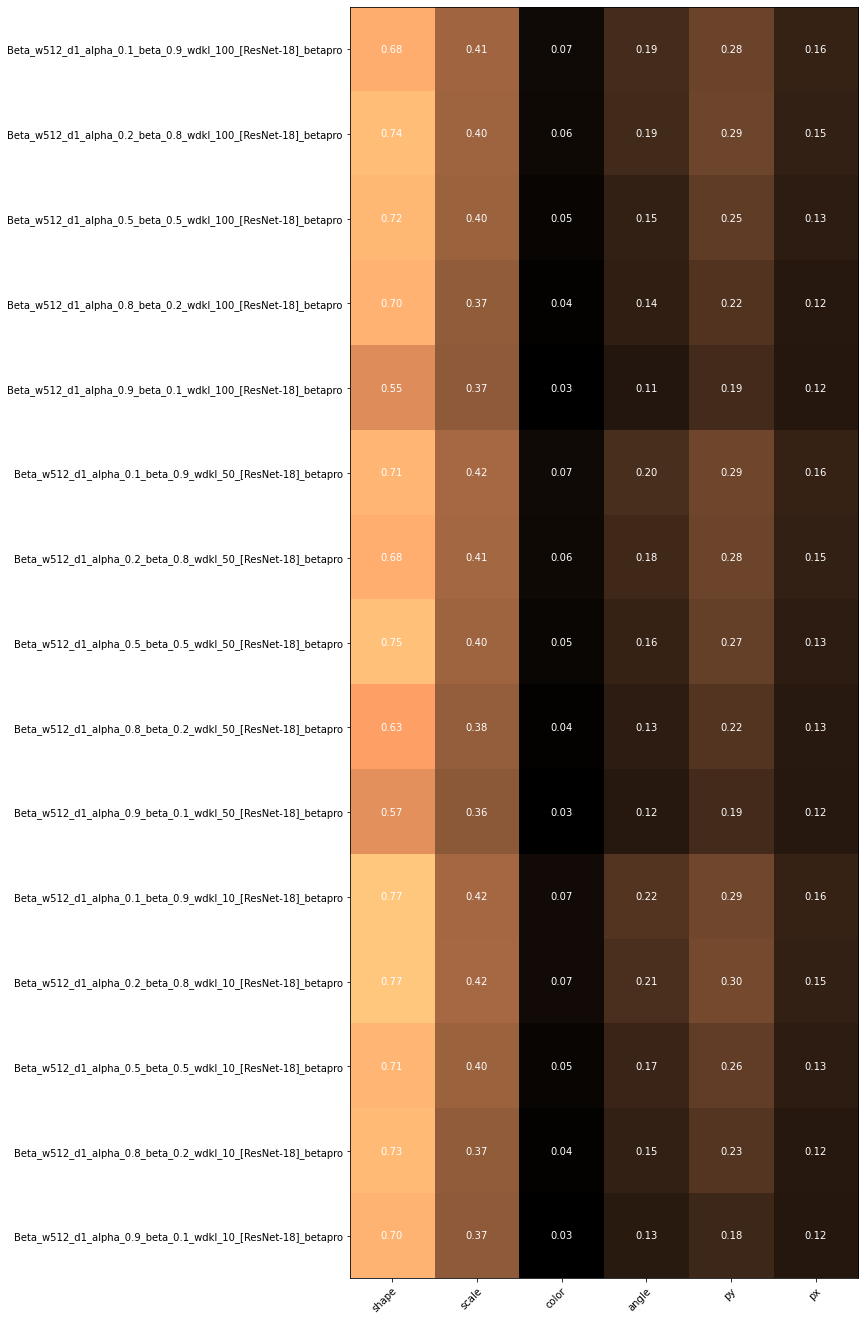

In [79]:
plot_mat(accs, names, target_variables, p_file=p_plot)

In [54]:
# row means
means = accs.mean(axis=1)

In [55]:
for model_name, mean in zip(names, means):
    print("{:<40}: {:.2f}".format(model_name, mean))

Beta_w8_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.27
Beta_w8_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.12
Beta_w16_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.33
Beta_w16_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.13
Beta_w32_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.38
Beta_w32_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.15
Beta_w64_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.40
Beta_w64_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.17
Beta_w128_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.42
Beta_w128_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.21
Beta_w256_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.43
Beta_w256_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.24
Beta_w512_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.43
Beta_w512_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_betapro: 0.28
Beta_w1024_d4_alpha_0.5_beta_0.5_wdkl_10_[ResNet-18]_bacbone: 0.45
Beta_w1024_d4_alpha